# Data Scraper

In [ ]:
#import libraries needed for scraping
from time import time, sleep
import random
import urllib
import pandas as pd
import numpy as np
from tqdm import tqdm
import requests
import bs4
from bs4 import BeautifulSoup
import re
from IPython.display import clear_output
import os
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.expected_conditions import visibility_of_element_located
from selenium.webdriver.common.action_chains import ActionChains
import winsound

In [ ]:
#form the URL, this is based on analysis of how the url is formed.
#samples of the URL:
#https://www.pets4homes.co.uk/sale/reptiles/local/
#https://www.pets4homes.co.uk/sale/reptiles/local/birmingham/
#https://www.pets4homes.co.uk/sale/reptiles/local/birmingham/page-11/
#https://www.pets4homes.co.uk/sale/dogs/german-shepherd/
#https://www.pets4homes.co.uk/sale/dogs/german-shepherd/local/page-35/
#https://www.pets4homes.co.uk/sale/dogs/german-shepherd/durham/page-2/
#https://www.pets4homes.co.uk/sale/reptiles/hermann-tortoise/liverpool/
url_template = "https://www.pets4homes.co.uk/{}/{}/local/{}/"
url_template_pages = "https://www.pets4homes.co.uk/{}/{}/local/{}/page-{}/"
#we have two url template because "page" don't exist in the url for page 1
listing_type = ['sale','adoption','stud']
pet_type = ['dogs','cats','reptiles','rodents','rabbits','horses','invertebrates','livestock', 'poultry', 'birds','fish']
cities = ['aberdeen','ayr_st-ives', 'barnsley_wimborne','basingstoke','bath','bedfordshire','birmingham','blackpool_plymouth',
         'bolton_appleby-in-westmorland', 'bournemouth', 'bradford_holsworthy', 'bridgend_brechin', 'brighton',
          'bristol_south-west-england', 'cambridge_gloucester', 'cardiff-county', 'carlisle', 'chelmsford', 'cheltenham',
         'chester', 'chesterfield', 'colchester', 'cornwall', 'coventry', 'crawley_witney', 'crewe', 'darlington', 'derby', 
         'devon', 'doncaster', 'dorset', 'dudley_cramlington', 'dundee', 'durham', 'eastbourne', 'edinburgh', 'essex', 'exeter',
         'glasgow', 'gloucester', 'grimsby', 'guildford', 'hampshire', 'hereford', 'hertfordshire', 'huddersfield','hull',
          'ipswich', 'kent', 'lancashire','leeds_maidstone','leicester','lincoln', 'liverpool', 'london','luton_newton-abbot',
         'maidstone', 'manchester', 'merseyside', 'middlesbrough', 'milton-keynes', 'newcastle-upon-tyne', 
          'newport_saffron-walden', 'northampton', 'norwich', 'nottingham', 'oxford', 'peterborough', 'plymouth', 
          'poole_nantwich', 'portsmouth', 'preston_brighton', 'reading', 'redditch', 'rotherham','sheffield', 'somerset', 
          'south-yorkshire', 'southampton', 'southend-on-sea', 'stockport', 'stoke-on-trent', 'suffolk', 
          'sunderland_cockermouth', 'surrey', 'swansea-county', 'swindon', 'taunton', 'telford', 'wakefield', 'walsall', 
          'warrington_olney', 'west-midlands', 'west-yorkshire', 'wigan', 'wolverhampton', 'worcester', 'worthing_dereham', 
          'wrexham-county', 'york']

In [ ]:
#function to check for captcha
def check_captcha (soup):
    if 'I am human' in soup.get_text(): 
        # text 'I am human' is only found when the captcha is triggered. 
        # Cloudflare captcha can be easily triggered by not accepting cookie.
        print('captcha detected')
        duration = 5000  # milliseconds
        freq = 440  # Hz
        winsound.Beep(freq, duration) #sound alert, might get irritating, probably won't work on mac
        input("Press Enter to continue...")#might look counter intuitive, this would pause the code until i press enter
    else:
        print('no captcha detected, proceed to scrape')

In [ ]:
#some of the data to be scraped exist on the header part of the HTML. However, these are formateed differently and
#lack some details that are desired
def scrape_header(soup):
    df = pd.DataFrame(columns=["Title","Description","photo_link","category", "price", "url",
                                              "seller_type", "seller_name", 'listing_type','pet_type'])
    for each in soup.find_all("script", type="application/ld+json"):
        entries = each.get_text()
        split = entries.split("\n")
        Title = split[3].replace('"name": "', '').replace('",', '')
        Description = split[4].replace('"description": "', '').replace('",', '').replace('\n,', '')
        Photo = split[5].replace('"image": "', '').replace('",', '')
        Category = split[7].replace('"category": "', '').replace('",', '')
        Price = split[11].replace('"price": "', '').replace('",', '')
        url =split[13].replace('"url": "', '').replace('",', '')
        seller_type = split[15].replace('"type": "', '').replace('",', '')
        seller_name = split[16].replace('"name":  "', '').replace('"', '')
        df = df.append({"Title":Title,"Description":Description,"photo_link":Photo,"category":Category, 
                                      "price":Price,"url":url, "seller_type":seller_type, "seller_name":seller_name,
                                      "listing_type":listing, "pet_type": pets},ignore_index=True)
    return df

In [ ]:
#function to scrape from HTML body. This function likely no longer work by this time. It has to be updated to match
#with the html tags of the website which change multiple times daily
def scrape_content(soup):
    df1 = pd.DataFrame(columns=["Title","price","species", "age", "gender", "description",
                                "seller_name", "seller_location", "seller_type", "listing_type","pet_type"])
    for each in soup.find_all("div", class_="rn lj"):
        entries = each.get_text()
        title = each.find('h2', {'class':'Bn'}).text
        price = each.find('span', {'class':'Cn'}).text
        info = each.find_all('span', {'class':'qv'})
        species = info[0].text
        try:
            age = info[1].text.replace('Age:  ', '')
        except:
            age = 'unknown'
        try:
            gender = info[2].text
        except:
            gender = 'unknown'
        description = each.find('span', {'class':'Dn'}).text
        seller_name = each.find('span', {'class':'Jn'}).text
        seller_location = each.find('span', {'class':'gt'}).text
        seller_type = each.find('div', {'class':'ef Ql ff'}).text
        df1 = df1.append({"Title":title, "price":price, "species":species, "age":age, "gender":gender,
                              "description":description, "seller_name":seller_name, "seller_location": seller_location,
                              "seller_type":seller_type, "listing_type":listing, "pet_type": pets},ignore_index=True)
    return df1

In [ ]:
#the main code of the scrapper
for city in set (cities):
    for pets in set(pet_type):
        for listing in set(listing_type):
            page = 1
            while page > 0: 
                # page loop. It's usually bad practice to make >0 loop. But in this case it is necessary since 
                # we don't know the actual number of pages to be scraped
                clear_output(wait=True) #clear the output every time we go to the next page to keep output clean 
                file = 'data_by_cities/header_'+str(city)+'.csv' #csv for header
                file1 = 'data_by_cities/body_'+str(city)+'.csv' #csv for body
                #the code will then try to read the csv files or create new one if they don't exist
                try: 
                    df_header = pd.read_csv(file , sep='\t', encoding='utf-8', index_col=0)
                    print('file successfully opened')
                except:
                    print('file not found, creating new file')
                    df_header = pd.DataFrame(columns=["Title","Description","photo_link","category", "price", "url",
                                              "seller_type", "seller_name", 'listing_type','pet_type'])
                    df_header.to_csv(file, sep='\t', encoding='utf-8')
                try: 
                    df_body = pd.read_csv(file1 , sep='\t', encoding='utf-8', index_col=0)
                    print('file successfully opened')
                except:
                    print('file not found, creating new file')
                    df_body = pd.DataFrame(columns=["Title","price","species", "age", "gender", "description",
                                                    "seller_name", "seller_location", "seller_type" , 
                                                    "listing_type","pet_type"])
                    df_body.to_csv(file1, sep='\t', encoding='utf-8')
                #save the size of the data scraped from html header and body
                headersize = df_header.shape
                bodysize = df_body.shape
                #page one has different url format
                if page == 1:
                    url = url_template.format(listing, pets, city)
                else:
                    url = url_template_pages.format(listing, pets, city, page)
                #open selenium browser
                options = webdriver.ChromeOptions()
                browser = webdriver.Chrome(ChromeDriverManager().install(),options = options)
                browser.get(url)
                title = (
                    #we need to wait because Cloudflare won't load the page immediately
                    WebDriverWait(driver=browser, timeout=15)
                    .until(visibility_of_element_located((By.CSS_SELECTOR, "h1"))).text
                )
                #take the page source code
                content = browser.page_source
                print(city,pets,listing,page) #this is done to know which loop the code is currently running
                soup = BeautifulSoup(content, 'lxml')
                check_captcha(soup)
                if 'We found 0' in soup.get_text(): #some pages sometimes have zero results, especially for stud
                    print('no result found')
                    break
                df_header = df_header.append(scrape_header(soup))
                df_body = df_body.append(scrape_content(soup))
                #This is to minimize duplicates on the fly. While it is not perfect, it is helpful
                #and then we save the data to the csv
                df_header = df_header[~df_header.duplicated(subset=['Title','Description', 'photo_link','category','url',
                                                                    'seller_type','listing_type',
                                                                    'pet_type'])].reset_index(drop=True)
                df_header.to_csv(file, sep='\t', encoding='utf-8')
                df_body = df_body[~df_body.duplicated()].reset_index(drop=True)
                df_body.to_csv(file1, sep='\t', encoding='utf-8')
                #check if there is new data. 
                #If we get new data from header but not body, it is likely that the html tags changed 
                #and we have to kill the loop, edit the scraper function and rework
                if df_body.shape == bodysize:
                    if df_header.shape == headersize:
                        print('no new data')
                    else:
                        winsound.Beep(600, 1000)
                        input('html tags is likely changed, please kill program')
                #detect next page button. The code is located within html body so it has to be updated together with scraper
                next_page = soup.find('a', {'class':'Fb gh Jb'})
                if next_page == None:
                    print('next page not found')
                    break
                else:
                    print ('next page found')
                    print('going to next page')
                    sleep(random.randint(10,15))
                    page +=1
            print('going to next listing type')
            sleep(random.randint(10,15))
        print('going to next pet type')
        sleep(random.randint(10,15))
    print('going to next city')

# Merge the CSV files

We would then merge the CSV files and do some basic cleaning

In [ ]:
import pandas as pd
import glob
combined_csv = pd.DataFrame()
for f in glob.glob(".\data_by_cities/body_*.csv"):

    df = pd.read_csv(f, sep='\t', encoding='utf-8', index_col=0) # make sure to apply correct settings 
    #(sep, parse_dates, headers, missing_values)
    #df["origin"] = f.replace(".\data_by_cities\\","").replace(".csv","") #add a column with a csv name
    combined_csv = combined_csv.append(df) #append new df to the "master" dataframe
#remove currency and change to float    
combined_csv["price"] = combined_csv["price"].str.replace("£","").str.replace(',', '').astype(float)
#some seller location data has (x km) following the location name
combined_csv["seller_location"] = combined_csv["seller_location"].str.replace(r'\([^()]*\)', '', regex=True)
#minor clean up on description removing new lines
combined_csv["description"] = combined_csv["description"].str.replace('\n', ' ').str.replace('\r', ' ')
combined_csv = combined_csv[~combined_csv.duplicated()].reset_index(drop=True)
combined_csv.to_csv("merged.csv", sep='\t', encoding='utf-8')
combined_csv

# EDA and Data Cleaning

## Preliminary analysis of the data

In [150]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [151]:
df = pd.read_csv('merged.csv' , sep='\t', encoding='utf-8', index_col=0)
df

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
48776      canarys for sale all colour plus new colours    40.0      Canaries   
48777  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
48778                Hand reared indian ringnecks babys   350.0       Parrots   
48779                    One yellow one orange canary.     60.0      Canaries   
48780                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
48776   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
48777   4 years    Male  Rainbow is a beautiful example of a blue and g...   
48778    1 year    Male  Hand reared cuddly silly tame little babys for...   
48779   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
48780   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
48776             Robert n.     Knottingley           Breeder         sale   
48777  The Bradford Birdman        Bradford  Licensed Breeder         sale   
48778              Waqar A.        Bradford           Breeder         sale   
48779             Amylia R.        Barnsley        Individual         sale   
48780              Ahmad R.        Bradford           Breeder         sale   

       pet_type  
0      reptiles  
1      reptiles  
2      reptiles  
3      reptiles  
4         birds  
...         ...  
48776     birds  
48777     birds  
48778     birds  
48779     birds  
48780     birds  

[48781 rows x 11 columns]

In [152]:
#check the merged data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48781 entries, 0 to 48780
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            48781 non-null  object 
 1   price            48781 non-null  float64
 2   species          48781 non-null  object 
 3   age              48781 non-null  object 
 4   gender           48781 non-null  object 
 5   description      48781 non-null  object 
 6   seller_name      48781 non-null  object 
 7   seller_location  48781 non-null  object 
 8   seller_type      48781 non-null  object 
 9   listing_type     48781 non-null  object 
 10  pet_type         48781 non-null  object 
dtypes: float64(1), object(10)
memory usage: 4.5+ MB


In [153]:
#a quick look of number of unique values
df.nunique()

Title              37519
price                394
species              438
age                  101
gender               139
description        44796
seller_name        20520
seller_location     1083
seller_type            5
listing_type           3
pet_type              11
dtype: int64

In [154]:
#examining gender column for unique values
df['gender'].value_counts()

unknown                11934
Mixed                   6199
Male                    3719
1 male                  2857
Female                  2796
                       ...  
03 male / 03 female        1
03 male / 01 female        1
03 male / 02 female        1
7 male / 8 female          1
05 male / 1 female         1
Name: gender, Length: 139, dtype: int64

We should combine these 'x number of male and y number of female' as mixed litters and remove the numbers from the others

In [155]:
df['gender'] = df['gender'].apply(lambda x: 'Mixed' if (' male' in x and 'female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Female' if (' female' in x) else x)
df['gender'] = df['gender'].apply(lambda x: 'Male' if (' male' in x) else x)
df['gender'].value_counts()

Mixed       20614
unknown     11934
Male         8850
Female       7085
Mare          139
Gelding       117
Stallion       42
Name: gender, dtype: int64

This is satisfactory enough. Mare, Gelding and Stallion are horses.

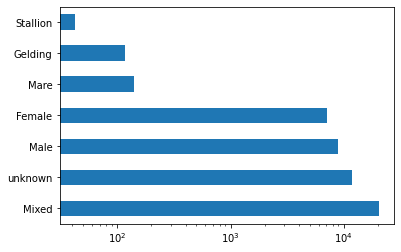

In [156]:
#bar plot
ax = df.gender.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [157]:
df.nunique()

Title              37519
price                394
species              438
age                  101
gender                 7
description        44796
seller_name        20520
seller_location     1083
seller_type            5
listing_type           3
pet_type              11
dtype: int64

In [158]:
df['seller_type'].value_counts()

Individual          29107
Breeder             16573
Licensed Breeder     2388
Rescue/Charity        707
Company                 6
Name: seller_type, dtype: int64

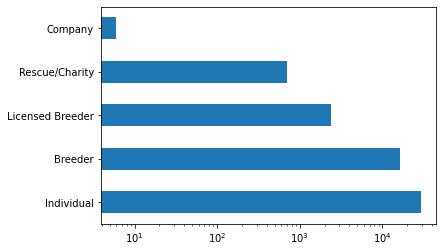

In [159]:
ax = df.seller_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [160]:
#examining seller location because there's so many of them
df['seller_location'].value_counts().tail(100)

Appleby In Westmorland    1
Гул                       1
Солфорд                   1
St Austell                1
Busveal                   1
                         ..
Wylam                     1
Chester Le Street         1
Filey                     1
Ulceby                    1
Ilkley                    1
Name: seller_location, Length: 100, dtype: int64

It is rather strange to have location data in foreign language. Probably should take a look at the posting.

In [164]:
df.loc[df['seller_location'] == 'Гул']

Title  price        species      age gender  \
46106  left one golden female❤️  550.0  Scottish Fold  8 weeks  Mixed   

                                             description    seller_name  \
46106  Adorable Scottish fold chinchilla kittens look...  Scottish Fold   

      seller_location seller_type listing_type pet_type  
46106             Гул     Breeder         sale     cats

It looks fine, only location column is in foreign language. Caution have to be taken as we might have listing completely in foreign language.

In [165]:
df.sort_values(by=['seller_location'], ascending=False).head(50)

Title   price  \
37123                      German Shepherd for sale  1600.0   
13543  Gold Chinchilla tuxedo British Shorthair boy   490.0   
13872                                  cute ragdoll   850.0   
25796  Gold Chinchilla tuxedo British Shorthair boy   490.0   
7157                    Find a new home for hamster     0.0   
25747                            Cute Black Cow Cat   500.0   
25751        Cute Last 4 British Short Hair Kittens   700.0   
46667  pure white chinchilla with other Accessories   200.0   
46565                                  Cute ragdoll   550.0   
11302                 A very cute French lop rabbit   100.0   
11996           Male and female gerbils ready to go    10.0   
11883                              gerbils for sale    10.0   
13929     Sweet Face Black Golden BSH for stud duty   200.0   
13417          6 British Shorthair kittens for sale   900.0   
13077          6 British shorthair kittens for sale   900.0   
34711  Rehome, 7 months British Shorthair Tabby Boy   650.0   
34814             Kitten for sale in central London   100.0   
34140        British Shorthair （lilac colour point）   900.0   
36705             10week old Italian greyhound boy   1500.0   
36420            Ready now!!! french bulldog female   750.0   
34692                        Beautiful Ragdoll boy!  2000.0   
34695               Beautiful Maine Coon for sale！！  1600.0   
36914                                  Handsome boy  1800.0   
36330           REHOME 5months old F2 Cockapoo Girl  1200.0   
41535                                          sold   900.0   
1176      Reggie 2.7 years old boy looking for date   100.0   
946                            Ready for new homes!   750.0   
34412             Pedigree short leg Minuet kitten.  1800.0   
48636                           French bulldog stud   123.0   
29592                                 Scotish fold    800.0   
46596                                          sold   550.0   
46634                                  Cat for stud   200.0   
46172                                 Scotish fold    800.0   
25644             Scottish Fold Straight ears 1 boy   200.0   
6963              Scottish Fold Straight ears 1 boy   200.0   
25395             Scottish Fold Straight ears 1 boy   200.0   
13123             Scottish Fold Straight ears 1 boy   200.0   
46106                      left one golden female❤️   550.0   
32799               GCCF Active Lilac British stud    250.0   
32812                    British shorthair kittens.   750.0   
9155     Miniature smooth hair  rare colour puppies  1500.0   
18683    Miniature smooth hair  rare colour puppies  1500.0   
3356                                  Best puppies   1300.0   
13593                         Stunning BSH kittens    850.0   
22                                     Blue Sphynx    850.0   
23                                    Sphynx kitten  1000.0   
8906                                French bulldog   1450.0   
32998       3ft Vivarium with DIY background, hides   165.0   
46378                           Bengal X Maine Coon   450.0   
46146      Stunning litter of kittens ready 11 June   200.0   

                 species        age   gender  \
37123    German Shepherd   8 months     Male   
13543  British Shorthair   14 weeks     Male   
13872            Ragdoll   6 months     Male   
25796  British Shorthair   13 weeks     Male   
7157             Hamster     1 year     Male   
25747  British Shorthair  10 months   Female   
25751  British Shorthair  10 months     Male   
46667         Chinchilla     1 year     Male   
46565            Ragdoll  10 months     Male   
11302         French Lop   4 months   Female   
11996             Gerbil   7 months    Mixed   
11883             Gerbil   4 months    Mixed   
13929  British Shorthair     1 year  unknown   
13417  British Shorthair    4 weeks    Mixed   
13077  British Shorthair    4 weeks    Mixed   
34711  British Shorthair   7 months     Male   
34814           

48 of our data has location column in foreign languages

In [166]:
#checking age column
df['age'].value_counts().tail(20)

2001              3
16 years          3
2000              3
Due in 6 weeks    3
2003 years        2
Due in 6 days     2
18 years          2
2004 years        2
20 years          2
2002 years        2
1998              1
2000 years        1
24 years          1
Due in 7 weeks    1
42 years          1
1999              1
66 years          1
2019 years        1
23 years          1
17 years          1
Name: age, dtype: int64

Some of these are very unusual. probably it's the year of birth. Longer living animals tends to have their year of birth recorded as age, horses in particular

In [167]:
df.loc[df['pet_type'] == 'horses']

Title   price  \
287                       tradition gypsy cob gelding  1200.0   
288                      Silversmith Burlesque Queen   2700.0   
549                                Hart braking sale   3000.0   
550       3 year old registered welsh section C Mare   2000.0   
551    9 month old mixed breed colt, slightly spotted   650.0   
...                                               ...     ...   
44422                  2 jenny donkeys very friendly    900.0   
44423                                Super alrounder      0.0   
46926                        1 year old to make 15.2+     0.0   
46927           29” palomino 3 year old shetland colt   700.0   
46928                          Stunning welsh c mare   3500.0   

               species   age    gender  \
287        Other Breed  2022   Gelding   
288          Miniature  2015      Mare   
549    Welsh Section A  2006      Mare   
550    Welsh Section C  2019      Mare   
551    Welsh Section A  2021  Stallion   
...                ...   ...       ...   
44422      Other Breed  2010      Mare   
44423  Welsh Section D  2009      Mare   
46926  Welsh Section D  2021   Gelding   
46927    Shetland pony  2019  Stallion   
46928  Welsh Section C  2018      Mare   

                                             description     seller_name  \
287    shamus is 2 years old wormed passport microchi...       nicola r.   
288    Silversmith Burlesque Queen This beautiful AMH...            Z A.   
549    Sadly I’ve come to the decision to let our gor...  Pugsforlove P.   
550    Walena Lucky Charm     Quality 3 year old regi...        Emily G.   
551    Ronnie is halter broken, will be groomed but n...        Tilly c.   
...                                                  ...             ...   
44422  Age 12 years, always been together Both passpo...         Mark G.   
44423    13 year old, section D, 14.2hh  M&M has a he...       Sharon P.   
46926  Not something I was planning on writing any ti...         Leah G.   
46927   For sale is Harry the 3 year old palomino col...           TJ V.   
46928  Stunning flashy welsh section c bay mare excel...       Alison R.   

          seller_location seller_type listing_type pet_type  
287                 Truro     Breeder         sale   horses  
288               Redruth  Individual         sale   horses  
549    Sturminster Newton  Individual         sale   horses  
550             Salisbury  Individual         sale   horses  
551             Wincanton  Individual         sale   horses  
...                   ...         ...          ...      ...  
44422             Wrexham  Individual         sale   horses  
44423            Holywell  Individual         sale   horses  
46926          Scunthorpe  Individual         sale   horses  
46927           Doncaster  Individual         sale   horses  
46928            Bradford     Breeder         sale   horses  

[298 rows x 11 columns]

298 is just right the sum of mare, gelding and stallion. We can also see that horses have their year of birth listed as their age.

In [168]:
df['pet_type'].value_counts()

dogs             23151
cats             11489
rabbits           4400
rodents           2321
birds             2068
reptiles          1955
poultry           1528
fish              1031
invertebrates      366
horses             298
livestock          174
Name: pet_type, dtype: int64

In [169]:
df['price'].value_counts()

1000.0    2139
200.0     1955
500.0     1737
1500.0    1736
150.0     1722
          ... 
27.0         1
785.0        1
1245.0       1
2499.0       1
1880.0       1
Name: price, Length: 394, dtype: int64

In [170]:
df.sort_values(by=['price'], ascending=False).head(30)

Title       price  \
24577            For TEMPORARY Foster/Temporary Adoption  11111111.0   
1530                      Working Cocker spaniel dog pup   9999999.0   
9625                  2 male Chihuahua puppies for sale    9999999.0   
42999                     OUTSTANDING 53 CHAMPS IN 5G BL   3333333.0   
28646                     OUTSTANDING 53 CHAMPS IN 5G BL   3333333.0   
200                                              Franco    1234567.0   
1144                                 Top Basset for Stud   1111111.0   
17105                 ❌••L4 FLUFFY CARRIERS••❌Coco girl❌    987654.0   
2821                                         Stolen coco    888888.0   
23757                                      ragdoll cross    150350.0   
4943   LOVELY BLACK GIRL TICA REG NO SILLY OFFERS PLEASE    123654.0   
22206                                Stunning. ...Proven    123456.0   
16776          Exceptional GCCF Proven Siberian for stud    123456.0   
45807   Createabullz LOADED-LUX full suit lilac and tan     123456.0   
27336                      BLACK AND BI COLOUR BABIES 🖤💙    123456.0   
26635                  XL BULLY girls and boys avalable     123456.0   
42576    CREATEABULLZ LOADED LUX PUPS lilac and blue tan    123456.0   
21183                                           Khaleesi    123456.0   
16739   Outstanding GCCF potential breed / show Siberian    123456.0   
22207              Duke, Proven KC registered  for stud.    123456.0   
38315                        Various Tarantulas For Sale    123456.0   
16261          Exceptional GCCF Proven Siberian for stud    123456.0   
32980                     Quince monitor Melinus offers?    123456.0   
28066   Createabullz LOADED-LUX full suit lilac and tan     123456.0   
7391                    Ball pythons with full vivariums    123456.0   
12088                        Female African Grey Parrot     123456.0   
9121                   XL BULLY girls and boys avalable     123456.0   
26903           KC REGISTERED GOLDEN RETRIEVER STUD ONLY    111111.0   
20367                          kc reg red poodle puppies     22000.0   
32003  Stunning Cream Boy Carrying PINK 💗 ❌Pied ❌Brindle     20000.0   

                 species       age   gender  \
24577  British Shorthair   3 years     Male   
1530      Cocker Spaniel  12 weeks     Male   
9625           Chihuahua   9 weeks     Male   
42999     Cocker Spaniel    1 week  unknown   
28646     Cocker Spaniel    1 week  unknown   
200     Golden Retriever   3 years  unknown   
1144        Basset Hound    1 year  unknown   
17105     French Bulldog  14 weeks    Mixed   
2821              Bengal   2 years  unknown   
23757            Ragdoll  10 weeks    Mixed   
4943              Sphynx    1 year  unknown   
22206   Golden Retriever   6 years  unknown   
16776           Siberian  7 months  unknown   
45807    English Bulldog   2 years  unknown   
27336             Sphynx  10 weeks    Mixed   
26635     American Bully   4 weeks    Mixed   
42576    English Bulldog   6 weeks    Mixed   
21183      Leopard Gecko   4 years   Female   
16739           Siberian    1 year  unknown   
22207   Golden Retriever   2 years  unknown   
38315         Tarantulas    1 year    Mixed   
16261           Siberian   3 years  unknown   
32980            Monitor   6 years     Male   
28066    English Bulldog   2 years  unknown   
7391        Python Snake   2 years    Mixed   
12088            Parrots  10 years   Female   
9121      American Bully   5 weeks    Mixed   
26903   Golden Retriever    1 year  unknown   
20367             Poodle   8 weeks    Mixed   
32003     French Bulldog   8 weeks     Male   

                                             description  \
24577  I'm looking for a loving TEMPORARY foster home...   
1530   One Liver Working cocker spaniel dog pup for s...   
9625   Here we have two beautiful stunning chihuahua ...   
42999  THE BEST IN BREED are here 🤗  SIRE is KC - slo...   
28646  THE BEST IN BREED are here 🤗    SIRE is KC - s...   


some of the pricing makes no sense, owner probably want potential buyer to contact them. We should drop these. these outliers make price histogram unworkable. We may use boxplot to identify them.

In [171]:
df.loc[df['price'] == 0.0]

Title  price            species  \
32                         African Cichlids bundle    0.0           Cichlids   
33                                Guppies for sale    0.0  Other/Mixed Breed   
234                          2 Beautiful Mini Lops    0.0           Mini Lop   
296            HORSFIELD TORTOISES - 2 years old.     0.0           Tortoise   
441                Full list baby ball python CB21    0.0       Python Snake   
...                                            ...    ...                ...   
46726         chocolate seal point female mini lop    0.0           Mini Lop   
46846                    BABY BLUE HOLICER RABBITS    0.0        Mixed Breed   
46885  RARE BABY HOLICER BABIES - READ DESCRIPTION    0.0  Continental Giant   
46888                             Rabbits for sale    0.0        English Lop   
46926                     1 year old to make 15.2+    0.0    Welsh Section D   

            age   gender                                        description  \
32       1 year  unknown  hi, I have got around 19 African cichlids look...   
33     12 weeks  unknown  2 1/2 months old mixed guppies for sale:  make...   
234      1 year    Mixed  We are looking to rehome our 2 gorgeous bunnie...   
296     2 years   Female  Adoption only!  Poppy & Penny are two beautifu...   
441      1 year    Mixed  Passione breeder based in Southampton, here to...   
...         ...      ...                                                ...   
46726    1 year   Female  daisy ❤️ chocolate seal point pure bred mini l...   
46846  6 months     Male  Iv had to put these babies under mixed breed a...   
46885  14 weeks    Mixed  - I have put them into the continental giant c...   
46888  15 weeks    Mixed  We have 5 beautiful rabbits for sale,they are ...   
46926      2021  Gelding  Not something I was planning on writing any ti...   

                seller_name seller_location seller_type listing_type  pet_type  
32               Margaret B     Peterculter     Breeder         sale      fish  
33                  Anil G.        Aberdeen  Individual         sale      fish  
234              Abigail W.         Helston  Individual     adoption   rabbits  
296                Caley A.           Truro  Individual     adoption  reptiles  
441    Eden Garden Reptiles     Southampton     Breeder         sale  reptiles  
...                     ...             ...         ...          ...       ...  
46726             Hip Hop B           Leeds     Breeder         sale   rabbits  
46846           Mini F Stud           Leeds     Breeder         sale   rabbits  
46885           Mini F Stud           Leeds     Breeder         sale   rabbits  
46888               Kian R.       Wakefield  Individual         sale   rabbits  
46926               Leah G.      Scunthorpe  Individual         sale    horses  

[774 rows x 11 columns]

Make sense for adoption, questionable for sale. These are either misplaced listing or placeholder price.

In [172]:
#function to create price histogram grouped by column value
def price_plot_hist (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xlabel(entry)
        plt.xticks(rotation=90)
        sns.distplot(x = data.loc[data[column] == entry].price)
        plt.show()

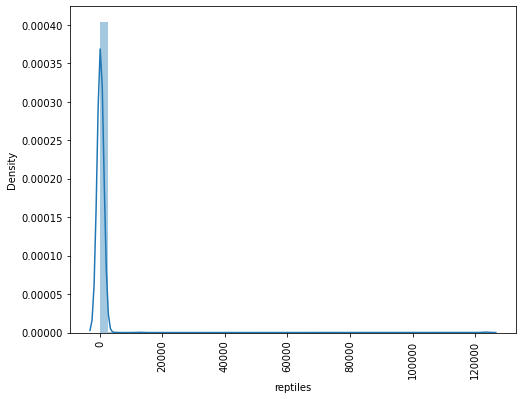

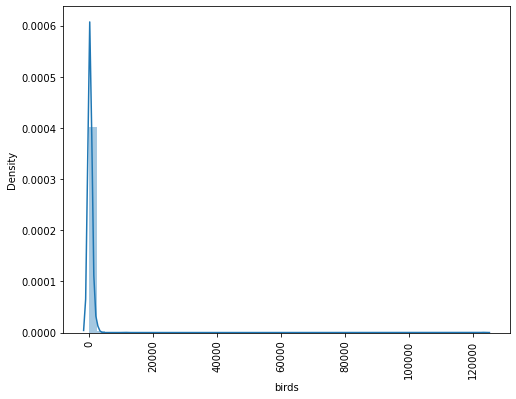

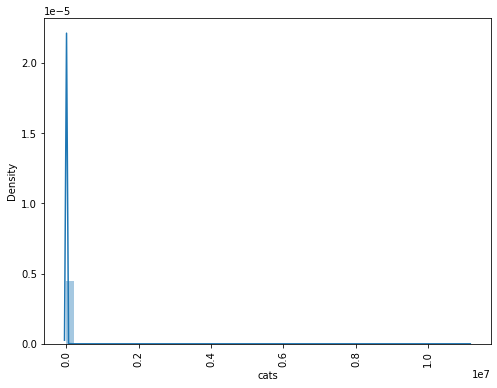

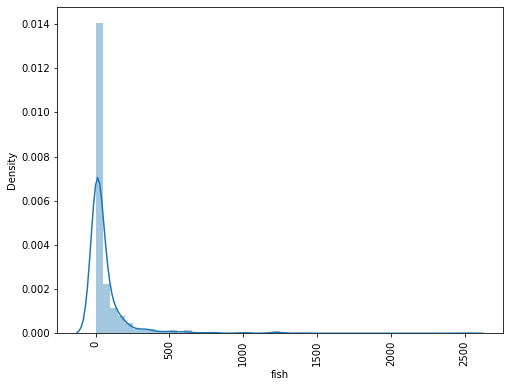

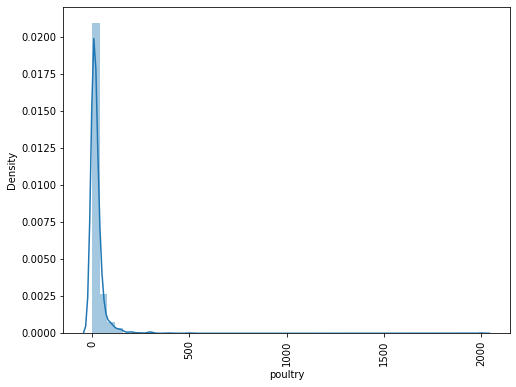

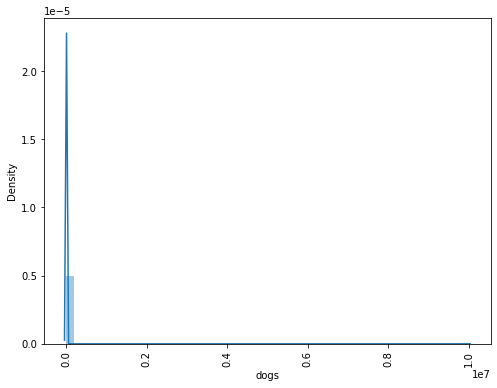

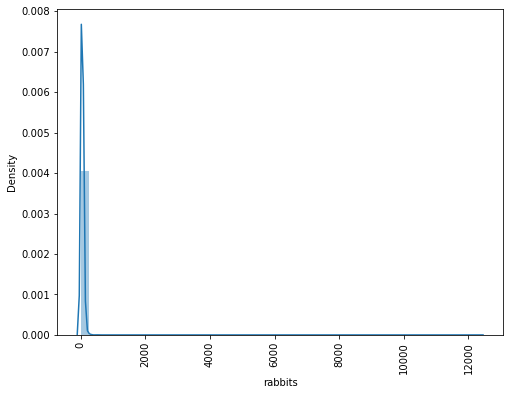

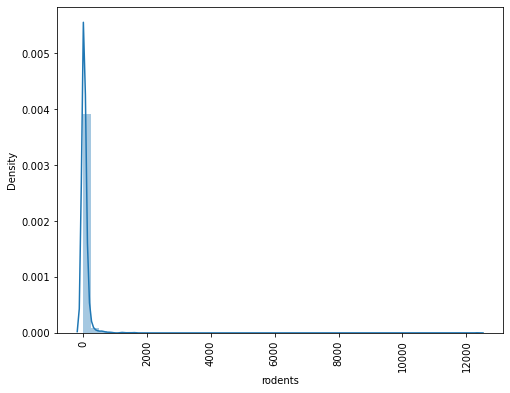

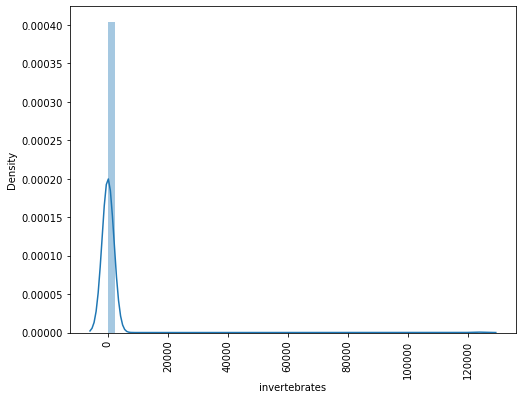

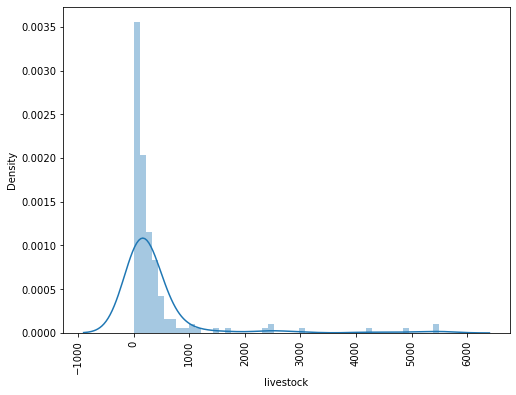

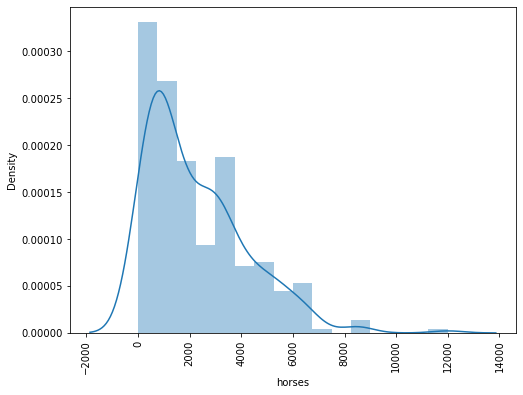

In [173]:
price_plot_hist (df,'pet_type')

Histogram don't look good because of extreme outliers. Horses and Lifestock look rather fine.

In [174]:
#function to create price boxplot grouped by column value
def price_plot_box (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = data.loc[data[column] == entry].price).set_title(entry)
        plt.show()

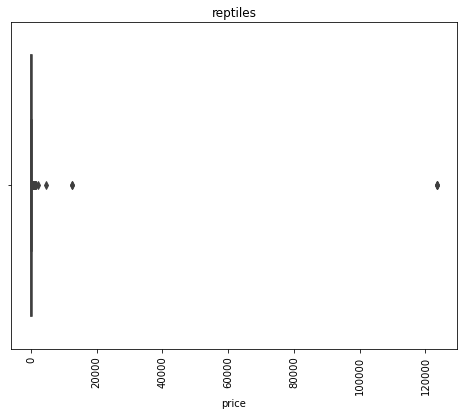

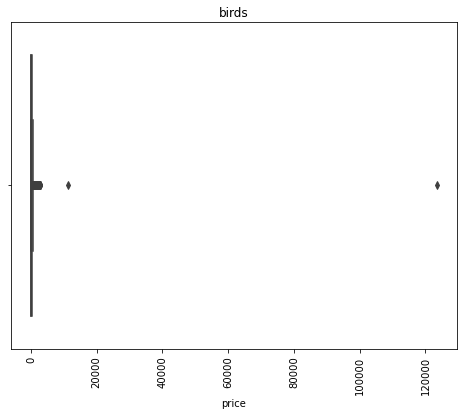

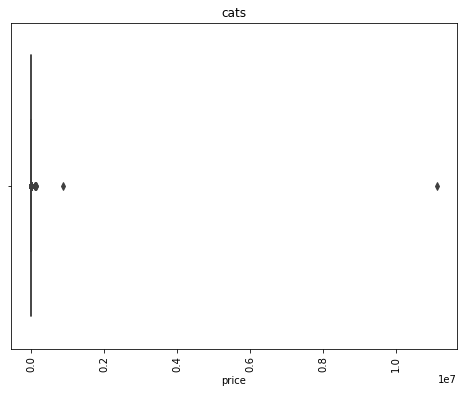

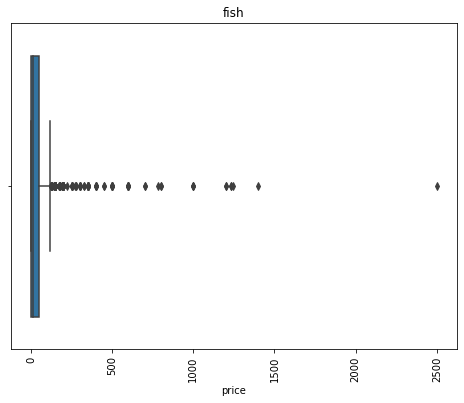

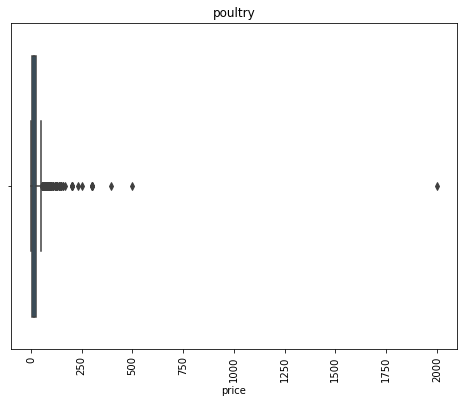

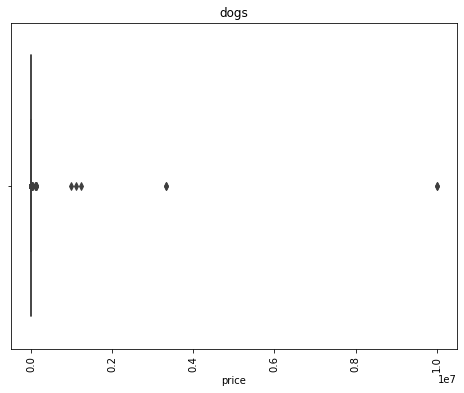

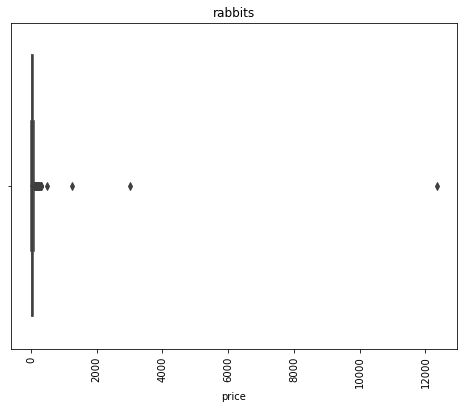

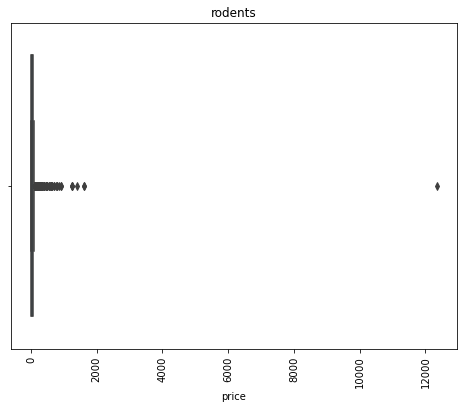

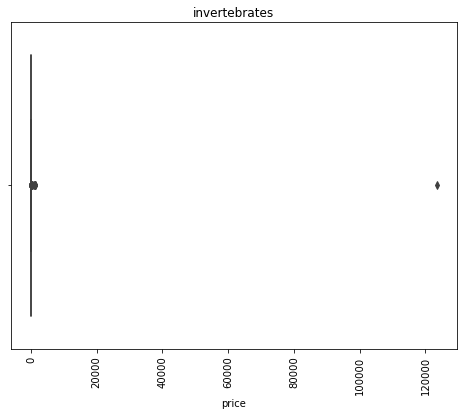

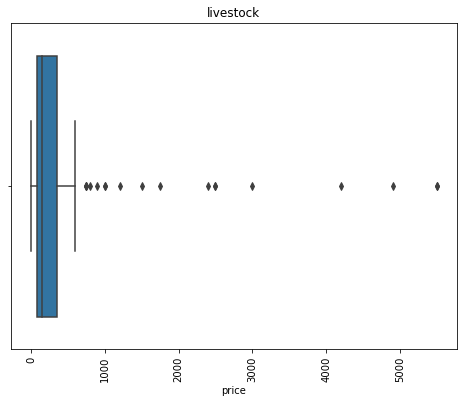

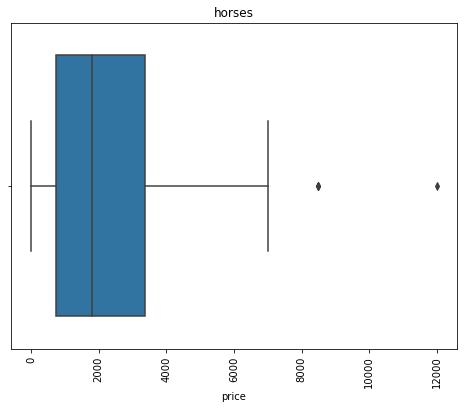

In [175]:
price_plot_box (df,'pet_type')

We could see that each pet types have their own outliers. 2000 doesn't look strange for dogs or cats but it's a sore thumb for poultry. This shows us that we should remove outliers by pet types.

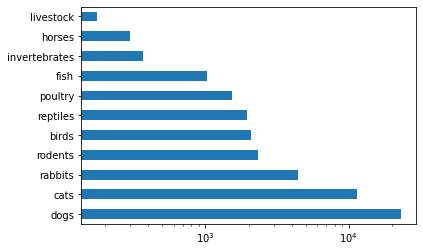

In [176]:
# plot value_counts of Series
ax = df.pet_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [177]:
df['age'].str.startswith('Due').value_counts()

False    48636
True       145
Name: age, dtype: int64

135 of the listing aren't born yet. Let us convert age to workable numbers, it might provide some useful insight. We can convert those that aren't due yet or just born to zero while the rest are converted to number of years.

In [178]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [179]:
def process_age_to_year(age):
    age = str(age)
    value = np.mean([int(s) for s in age.split() if s.isdigit()])
    if "Due" in age:
        newage = 0
    elif "Just Born" in age:
        newage = 0
    elif "month" in age: 
        newage = value/12
    elif "week" in age: 
        newage = value/52
    elif "day" in age: 
        newage = value/365
    elif "year" in age: 
        if value > 100:
            newage = 2022 - value
        else:
            newage = value
    else:
        if age == 'unknown':
            newage = np.nan
        else:
            age = int(age)
            if age > 100:
                newage = 2022 - age
            else:
                newage = age
    return newage

In [180]:
df['year'] = df['age'].map(lambda x: process_age_to_year(x))

In [181]:
df

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
48776      canarys for sale all colour plus new colours    40.0      Canaries   
48777  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
48778                Hand reared indian ringnecks babys   350.0       Parrots   
48779                    One yellow one orange canary.     60.0      Canaries   
48780                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
48776   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
48777   4 years    Male  Rainbow is a beautiful example of a blue and g...   
48778    1 year    Male  Hand reared cuddly silly tame little babys for...   
48779   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
48780   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
48776             Robert n.     Knottingley           Breeder         sale   
48777  The Bradford Birdman        Bradford  Licensed Breeder         sale   
48778              Waqar A.        Bradford           Breeder         sale   
48779             Amylia R.        Barnsley        Individual         sale   
48780              Ahmad R.        Bradford           Breeder         sale   

       pet_type      year  
0      reptiles  3.000000  
1      reptiles  1.000000  
2      reptiles  4.000000  
3      reptiles  0.750000  
4         birds  0.173077  
...         ...       ...  
48776     birds  0.134615  
48777     birds  4.000000  
48778     birds  1.000000  
48779     birds  2.000000  
48780     birds  9.000000  

[48781 rows x 12 columns]

It looks good. We have successfully converted age column to year.

In [182]:
df.describe()

price          year
count  4.878100e+04  48766.000000
mean   1.559520e+03      0.958430
std    8.475819e+04      1.727980
min    0.000000e+00      0.000000
25%    8.500000e+01      0.153846
50%    3.500000e+02      0.250000
75%    1.000000e+03      1.000000
max    1.111111e+07     66.000000

In [183]:
def year_plot_box (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = data.loc[data[column] == entry].year).set_title(entry)
        plt.show()

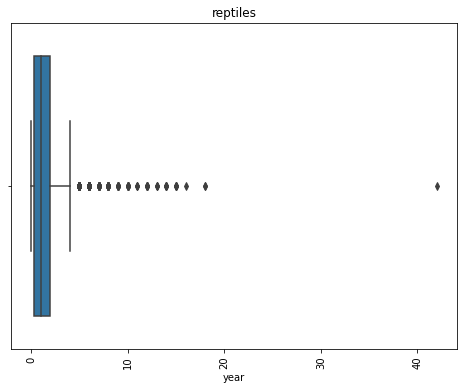

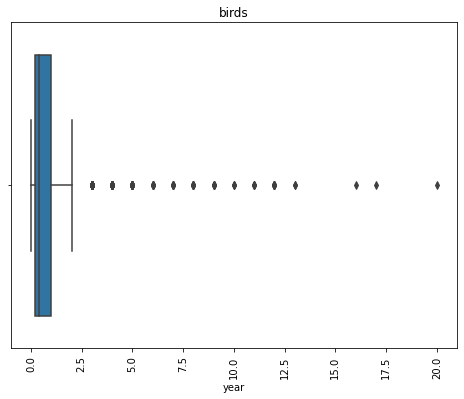

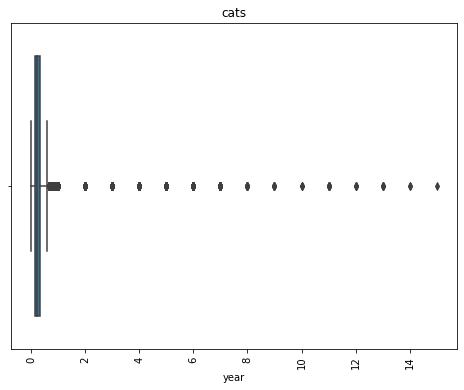

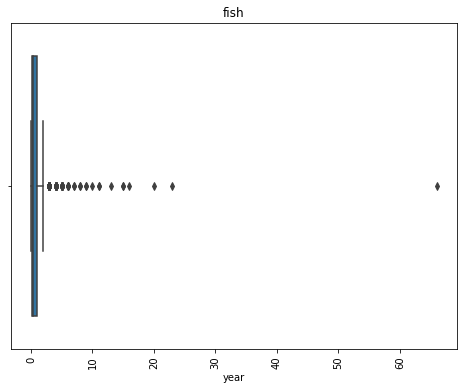

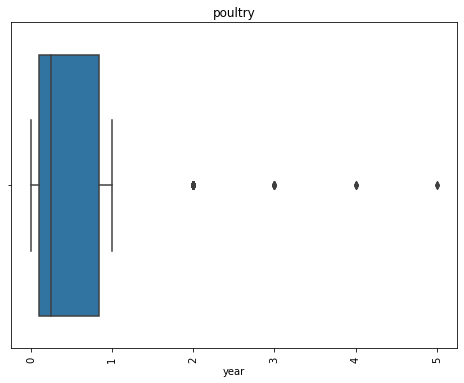

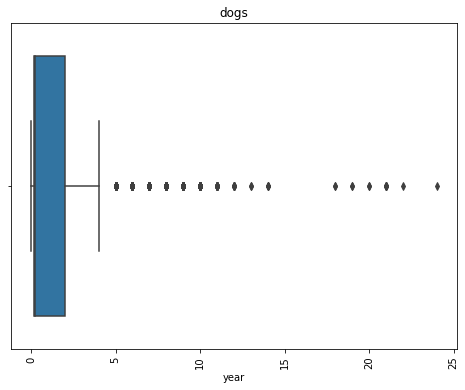

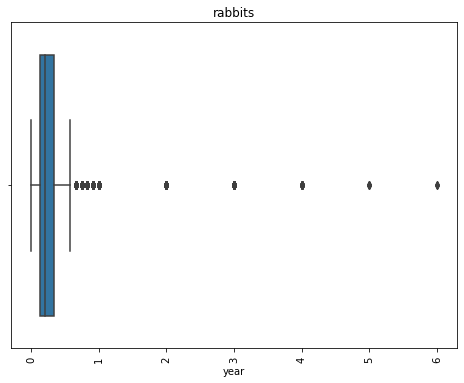

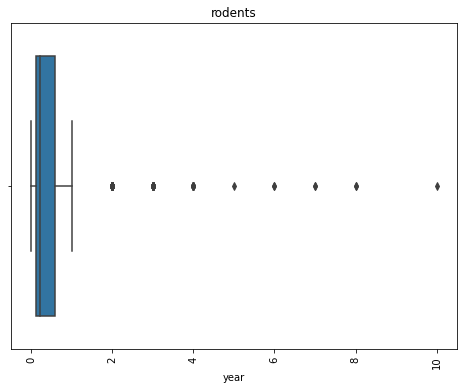

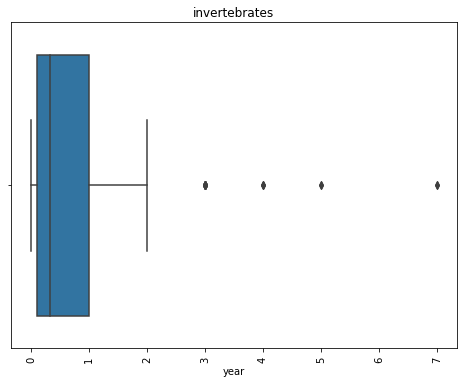

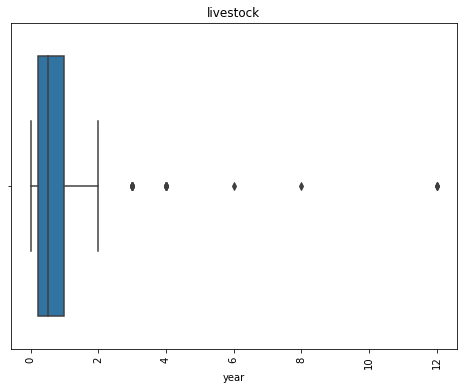

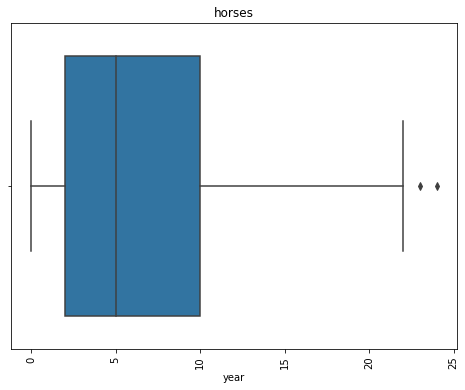

In [184]:
year_plot_box (df,'pet_type')

There are some strange values that look rather unrealistic.

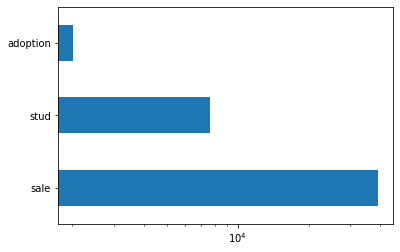

In [185]:
ax = df.listing_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [186]:
df.corr()

price      year
price  1.000000  0.000045
year   0.000045  1.000000

After looking more at the data, what I'm sure of:
- There are duplicates that scraper couldn't identify. This is likely because title and description changed during scraping.
- Some sellers put deposit as sale price, which explains why some listing looks extremely cheap
- Some cheap listing is because owner couldn't take care of the pet anymore and look for new family to take over
- Odd entries are because owner want to get in contact before deciding the sale
- Some listing are service offers which we are not interested in
- Correlation between price and age is weak

Data that we need to remove:
- Duplicates
- Those that aren't actual sale price. The hard part is identifiying them.
- Listing that are not in English. Those are likely to cause problems with NLP model.
- Those that are services (microchipping, dog walking, etc)

To remove duplicates, we could ignore description and title column. The other columns are less likely to change after reposting.

Identify those listing not in english with langdetect.

## Dropping outliers for each pet type

In [187]:
df1=df
df1.dropna(inplace=True)
df1.drop(df1[(df1['price'] > 22000)].index, inplace=True) #those above 22000 are exceedingly exhorbitant
df1.drop(df1[(df1['price'] == 12345.0)].index, inplace=True) #the number look suspicious, checking the entry proved suspicion
df1.drop(df1[(df1['price'] == 1234.0)].index, inplace=True) #same as above
df1.drop(df1[(df1['pet_type'] == 'reptiles') & (df1['price'] > 1200)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'birds') & (df1['price'] > 10000)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'fish') & (df1['price'] > 2000)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'poultry') & (df1['price'] > 1000)].index, inplace=True)
df1.drop(df1[(df1['pet_type'] == 'rabbits') & (df1['price'] > 1000)].index, inplace=True)
df1.drop(df1[(df1['listing_type'] == 'sale') & (df1['Title'].str.contains('service'))].index, inplace=True)
df1.drop(df1[(df1['listing_type'] == 'sale') & (df1['Title'].str.contains('Services'))].index, inplace=True)
df1.drop(df1[(df1['listing_type'] == 'sale') & (df1['price'] == 0.0)].index, inplace=True) #sale couldn't be zero
#other listings don't look unusual enough to drop
#sometimes title and description changes during scraping and we need to remove those.
df1 = df1[~df1.duplicated(subset=['price', 'species', 'age', 'gender', 'seller_name', 'seller_location','seller_type',
                                  'listing_type','pet_type'])].reset_index(drop=True)
#dropping non latin alphabet location
df1 = df1[~df1['seller_location'].str.match(r'.*[^\x00-\xFF]')].reset_index(drop=True)
df1

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
41659      canarys for sale all colour plus new colours    40.0      Canaries   
41660  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
41661                Hand reared indian ringnecks babys   350.0       Parrots   
41662                    One yellow one orange canary.     60.0      Canaries   
41663                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
41659   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
41660   4 years    Male  Rainbow is a beautiful example of a blue and g...   
41661    1 year    Male  Hand reared cuddly silly tame little babys for...   
41662   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
41663   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
41659             Robert n.     Knottingley           Breeder         sale   
41660  The Bradford Birdman        Bradford  Licensed Breeder         sale   
41661              Waqar A.        Bradford           Breeder         sale   
41662             Amylia R.        Barnsley        Individual         sale   
41663              Ahmad R.        Bradford           Breeder         sale   

       pet_type      year  
0      reptiles  3.000000  
1      reptiles  1.000000  
2      reptiles  4.000000  
3      reptiles  0.750000  
4         birds  0.173077  
...         ...       ...  
41659     birds  0.134615  
41660     birds  4.000000  
41661     birds  1.000000  
41662     birds  2.000000  
41663     birds  9.000000  

[41664 rows x 12 columns]

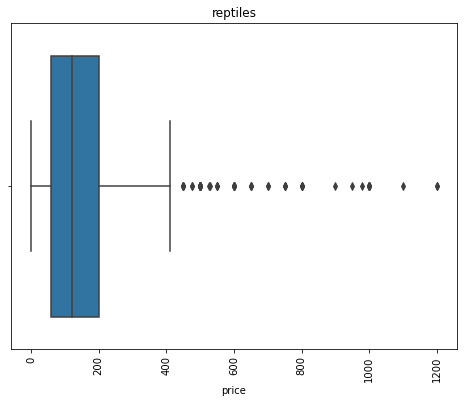

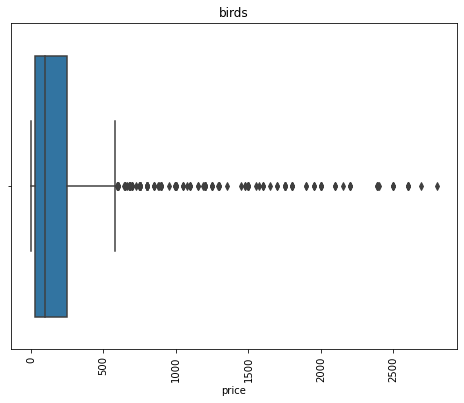

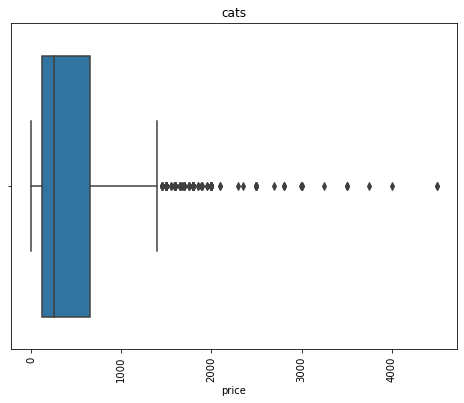

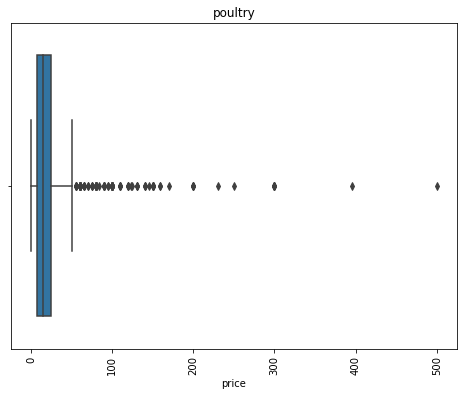

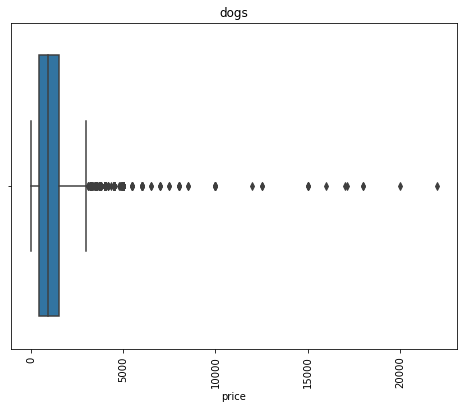

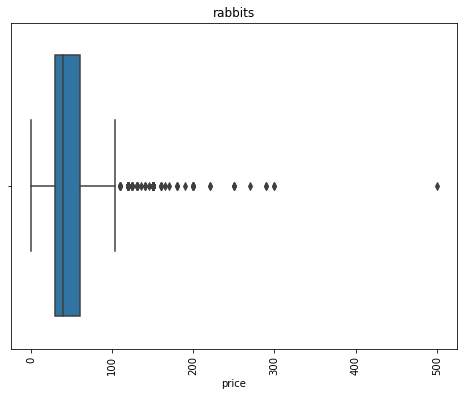

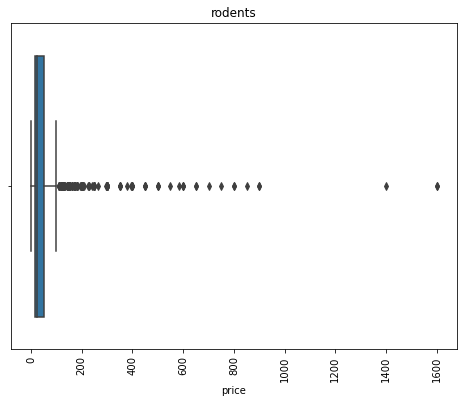

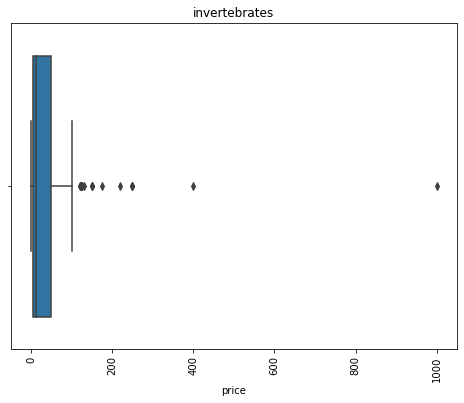

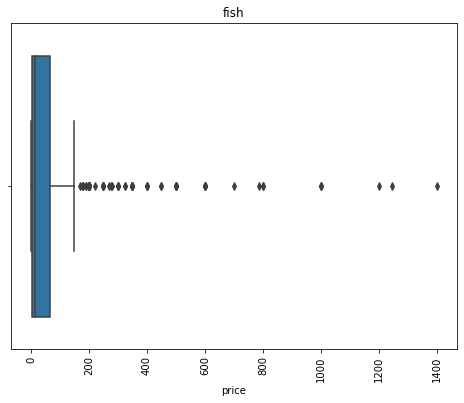

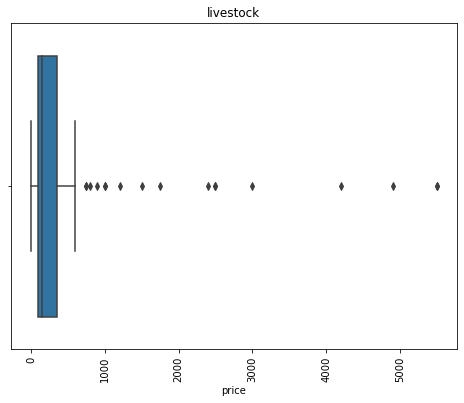

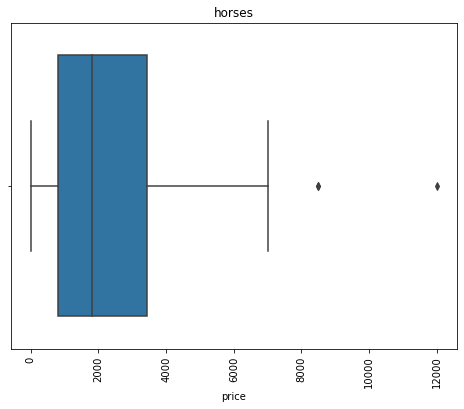

In [188]:
price_plot_box (df1,'pet_type')

In [189]:
df1.sort_values(by=['price'], ascending=False).head(30)

Title    price  \
18071                          kc reg red poodle puppies  22000.0   
27883  Stunning Cream Boy Carrying PINK 💗 ❌Pied ❌Brindle  20000.0   
28223           Lilac & Tan Platinum Carrying Pink (caL)  18000.0   
8729                           2 female fluffy frenchies  18000.0   
38823          *STUNNING LITTER ALL FLUFF0Y L1 CARRIERS*  17148.0   
21427           VISUAL FLUFFY LILAC FRENCHIES GIRL \BOYS  17000.0   
7381                  Fluffy Frenchie and Fluffy Carrier  16000.0   
25074                          French bulldogs for sale   15000.0   
36762                       Merle Fluffy Carrier Female   15000.0   
28042           Outstading Cream, Pink (caL) Carrier Boy  15000.0   
39977                       4 Pedigree Shihtzu Boys left  12500.0   
15584                                Isabella Merle Male  12500.0   
23220      First merle Billy the kid pups in the world!   12000.0   
1731            Exceptionally well Marked Skewbald mare   12000.0   
18088            KC* 2nd in the world STARBUCKS Litter ！  10000.0   
7281                    Lilac and Tan carrying isabella   10000.0   
8318                             VITA X BILLY THE KID !   10000.0   
23000                            VITA X BILLY THE KID !   10000.0   
24989                     BOSSY CONGO X MAJESTY BREEDING  10000.0   
5643           lilac and tan fluffy carrier adult female  10000.0   
3239     Catahoula Leopard Dog puppies puppy not pointer   9999.0   
9265                             Visual fluffy frenchie    8500.0   
18806                                    Bow 15.2hh cob    8500.0   
13427                            Visual fluffy frenchie    8500.0   
25432           Perfect Allrounder Teenagers Dream 14.2    8500.0   
25810  Kc baby cookies fozzy male testable and l4 car...   8000.0   
28307                    Fluffy carrier French bull dog    8000.0   
31712               Amazing Chow Chows. Merles & Solids    8000.0   
38462     Full Isabella female ready to for her new home   8000.0   
15602               Top Champion Pedigree Pocket Bullies   7999.0   

                 species        age   gender  \
18071             Poodle    8 weeks    Mixed   
27883     French Bulldog    8 weeks     Male   
28223     French Bulldog    8 weeks  unknown   
8729      French Bulldog   12 weeks   Female   
38823     French Bulldog     1 year  unknown   
21427     French Bulldog    3 weeks    Mixed   
7381      French Bulldog   12 weeks   Female   
25074     French Bulldog   10 weeks    Mixed   
36762     French Bulldog     1 year   Female   
28042     French Bulldog    8 weeks     Male   
39977           Shih Tzu    5 weeks     Male   
15584     French Bulldog    8 weeks     Male   
23220     American Bully   12 weeks    Mixed   
1731   British Warmblood       2018     Mare   
18088          Chow Chow    3 weeks    Mixed   
7281      French Bulldog    3 years  unknown   
8318      American Bully    8 weeks    Mixed   
23000     American Bully    7 weeks    Mixed   
24989     American Bully    7 weeks  unknown   
5643      French Bulldog   9 months  unknown   
3239         Mixed Breed   14 weeks    Mixed   
9265      French Bulldog  10 months  unknown   
18806          Irish Cob       2008     Mare   
13427     French Bulldog  11 months  unknown   
25432          Connemara       2011  Gelding   
25810     French Bulldog   7 months  unknown   
28307     French Bulldog    7 weeks  unknown   
31712          Chow Chow    5 weeks    Mixed   
38462     French Bulldog   13 weeks    Mixed   
15602     American Bully    6 weeks    Mixed   

                                             description  \
18071  beautiful thick coats and very sociable happy ...   
27883  I have one stunning quality boy available. No ...   
28223  I have one stunning quality boy available. No ...   
8729   1xfluffy carrier girl -blue and tan B/b E/e £6...   
38823  Our amazing Nala coat color   DNA: ? AtAt/dd/c...   
21427  Our lovely girl gave birth to 3 beautiful babi...   
73

In [190]:
df1.describe()

price          year
count  41664.000000  41664.000000
mean     656.732335      0.946517
std      805.959946      1.722896
min        0.000000      0.000000
25%      100.000000      0.153846
50%      392.500000      0.250000
75%     1000.000000      1.000000
max    22000.000000     66.000000

In [346]:
df1.corr()

price      year
price  1.000000 -0.106195
year  -0.106195  1.000000

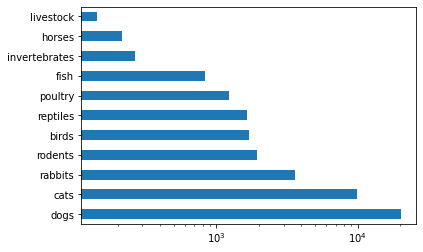

In [345]:
# plot value_counts of Series
ax = df1.pet_type.value_counts().plot(kind='barh')
ax.set_xscale('log')

In [343]:
def price_std (data, column):
    entries = data[column].unique()
    standard_deviation = []
    for entry in entries:
        print('price standard deviation of', entry, 'is', data.loc[data[column] == entry].std()['price'])
        standard_deviation.append((entry, data.loc[data[column] == entry].std()['price']))
    plt.bar(range(len(standard_deviation)), [val[1] for val in standard_deviation], align='center')
    plt.xticks(range(len(standard_deviation)), [val[0] for val in standard_deviation])
    plt.xticks(rotation=70)
    plt.show()

price standard deviation of reptiles is 142.11998679458102
price standard deviation of birds is 422.9659559764834
price standard deviation of cats is 407.9605452585543
price standard deviation of poultry is 37.87482128572374
price standard deviation of dogs is 891.341278828216
price standard deviation of rabbits is 30.276332681370707
price standard deviation of rodents is 102.73226035690523
price standard deviation of invertebrates is 77.25667762986573
price standard deviation of fish is 142.91787789466505
price standard deviation of livestock is 920.8218695507916
price standard deviation of horses is 1905.0442627069112


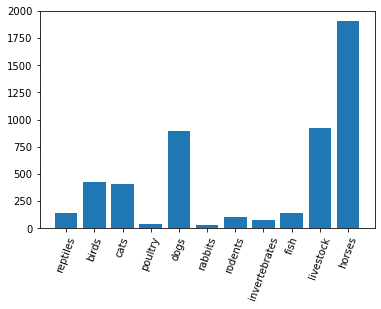

In [344]:
price_std (df1,'pet_type')

## Saving the data so I don't have to rerun the code above again.

In [191]:
df1.to_csv('cleaned_data.csv', sep='\t', encoding='utf-8')

# Building the models

## Load in the the cleaned data

In [192]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
df_clean = pd.read_csv('cleaned_data.csv' , sep='\t', encoding='utf-8', index_col=0)

In [193]:
df_clean

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
41659      canarys for sale all colour plus new colours    40.0      Canaries   
41660  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
41661                Hand reared indian ringnecks babys   350.0       Parrots   
41662                    One yellow one orange canary.     60.0      Canaries   
41663                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
41659   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
41660   4 years    Male  Rainbow is a beautiful example of a blue and g...   
41661    1 year    Male  Hand reared cuddly silly tame little babys for...   
41662   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
41663   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
41659             Robert n.     Knottingley           Breeder         sale   
41660  The Bradford Birdman        Bradford  Licensed Breeder         sale   
41661              Waqar A.        Bradford           Breeder         sale   
41662             Amylia R.        Barnsley        Individual         sale   
41663              Ahmad R.        Bradford           Breeder         sale   

       pet_type      year  
0      reptiles  3.000000  
1      reptiles  1.000000  
2      reptiles  4.000000  
3      reptiles  0.750000  
4         birds  0.173077  
...         ...       ...  
41659     birds  0.134615  
41660     birds  4.000000  
41661     birds  1.000000  
41662     birds  2.000000  
41663     birds  9.000000  

[41664 rows x 12 columns]

## Predict if the pet is expensive or affordable

Our cleaned data has 41664 rows. Before we build a model to predict price (the actual number), let us build a model to predict a binary variable if a pet is expensive or affordable (ignoring mantenance cost). We could use the median as separator, expensive if the price is above median, affordable if below it.

In [50]:
df_clean.describe()

price          year   price_class
count  41664.000000  41664.000000  41664.000000
mean     656.732335      0.946517      0.500000
std      805.959946      1.722896      0.500006
min        0.000000      0.000000      0.000000
25%      100.000000      0.153846      0.000000
50%      392.500000      0.250000      0.500000
75%     1000.000000      1.000000      1.000000
max    22000.000000     66.000000      1.000000

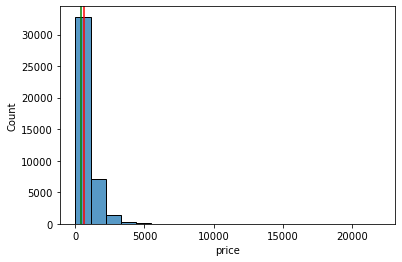

In [51]:
ax = sns.histplot(df_clean['price'], bins=20)
ax.axvline(df_clean['price'].mean(), c='r')
ax.axvline(df_clean['price'].median(), c='g')

Our data is rather skewed on one side. This is probably because there are a lot of expensive dogs. Dogs overall have higher price range.

In [52]:
median_price = np.median(df_clean.price)
median_price

392.5

In [53]:
df_clean['price_class'] = [1 if i > median_price else 0 for i in df_clean.price]

In [54]:
df_clean.price_class.value_counts()

1    20832
0    20832
Name: price_class, dtype: int64

And the baseline accuracy is

In [55]:
df_clean.price_class.value_counts(normalize=True)

1    0.5
0    0.5
Name: price_class, dtype: float64

Although our data is skewed on one side, interestingly our median is a unique value that split the data 50-50

### Create a classification model to predict High/Low price.

In [103]:
#import packages and dependency for our models
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import mean_squared_error, precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from IPython.display import display, clear_output
scaler = StandardScaler()

In [57]:
#fit the model with a function to save some time from typing the same thing over and over again
#input model name, training data and test data (and optionally number of cross validation, the default is 5)
#printed output are the cv score, training score and test score
def model_fitter(model, X_train, y_train, X_test, y_test, cv=5):
    model.fit(X_train, y_train)
    cv_score = np.mean(cross_val_score(model, X_train, y_train, cv=cv))
    training_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print ('the cv score is',cv_score)
    print ('the training score is',training_score)
    print ('the test score is',test_score)

In [58]:
def RMSE (model, x, y):
    y_pred = model.predict(x)
    return mean_squared_error(y, y_pred)

In [59]:
#dummify and train test split
#our variables are mostly categorical. To fit our model, we need to dummify it first.
X = pd.get_dummies(df_clean[['pet_type']])
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = df_clean.price_class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)
#the first choice is logistic regression which is the simplest classification model and therefore fast to perform. 
#While the result is likely not the best, it can serve as a benchmark
logreg = LogisticRegression()
model_fitter(logreg, X_train, y_train, X_test, y_test)

the cv score is 0.7921409736053113
the training score is 0.7921409957481826
the test score is 0.79016


In [60]:
RMSE(logreg, X, y)

0.20845334101382487

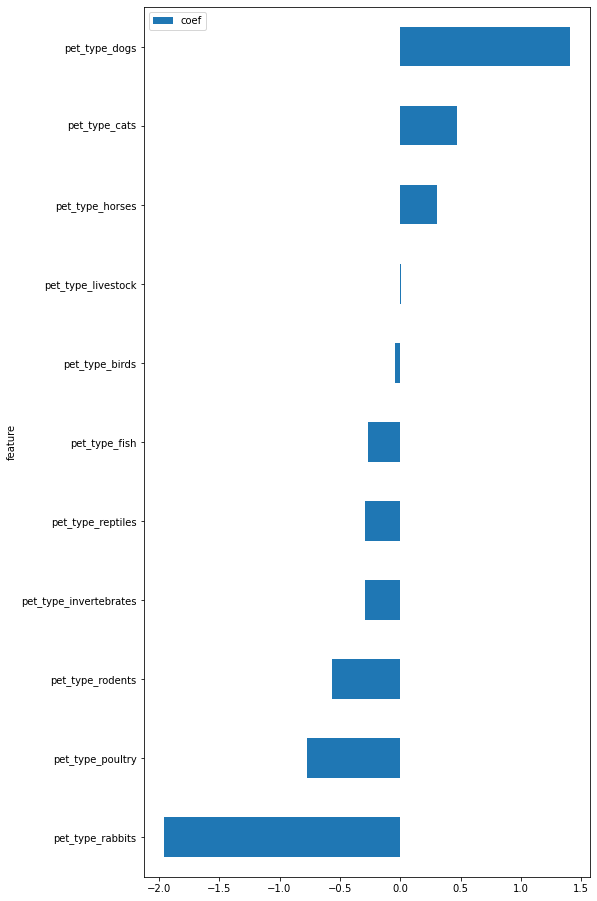

In [61]:
pd.DataFrame(list(zip(X.columns, logreg.coef_[0])), 
             columns=['feature', 'coef'])\
    .sort_values(by='coef') \
    .plot(kind='barh', x='feature', y='coef', figsize=(8, 16))
plt.show()

Dogs are more expensive compared with others as expected. Rather surprising that rabbits have the lowest coefficient. Let's try another algorithm such as KNN (K-nearest neighbour) that is non-parametric and supports non linear solutions in comparison with parametric linear only logistic model. The number of neighbors have to be adjusted carefully to give the best result.

In [65]:
knn = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn, X_train, y_train, X_test, y_test)

the cv score is 0.7495199020190924
the training score is 0.7222603209436291
the test score is 0.72544


In [68]:
RMSE(knn, X, y)

0.2767857142857143

Let's build another model, with more variables this time, it might give us better result.

In [69]:
#dummify and train test split
X_more = pd.get_dummies(df_clean[['pet_type','seller_type','listing_type', 'species' , 'gender']])
X_more = pd.DataFrame(scaler.fit_transform(X_more), columns=X_more.columns)
y_more = df_clean.price_class
X_more_train, X_more_test, y_more_train, y_more_test = train_test_split(X_more,
                                                    y_more, test_size=0.3, random_state=8)

In [70]:
log_more = LogisticRegression(penalty='none', max_iter=1000)
model_fitter(log_more, X_more_train, y_more_train, X_more_test, y_more_test)

the cv score is 0.8982305867213576
the training score is 0.9030311342751337
the test score is 0.90024


In [71]:
RMSE(log_more, X_more, y_more)

0.09780625960061444

In [72]:
knn_more = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn_more, X_more_train, y_more_train, X_more_test, y_more_test)

the cv score is 0.891372799198167
the training score is 0.9017967357015498
the test score is 0.89272


In [73]:
RMSE(knn_more, X_more, y_more)

0.10092645929339478

Increasing the number of variables gives overall better results.

### NLP model to predict high or low

In [74]:
# Create a few new variables in dataframe to represent interesting features of a listing title and description
# I'm not sure how to do it in elegant way, so I would just create a function for this.
# converts text to raw text with no punctuations or numbers.
import re
def clean_text(row):

    regex = re.compile("[^a-zA-Z']")
    row = row.lower()
    row = regex.sub(' ', row)
    row = ' '.join(row.split())
    regex = re.compile("\'")
    row = regex.sub('', row)

    return row
def standardize(row):
    """
       Standardize text variations: 'gtp' -> 'green tree python',
                                    'JR' -> 'Jack Russell',
        The list would be expanding
     """
    
    row = row.replace(r'gtp', 'green tree python')
    row = row.replace(r'JR','Jack Russell')
    row = row.replace(r'canarys','canary').replace(r'canaries','canary')
    row = row.replace(r'babys','baby').replace(r'babies','baby')
    row = row.replace(r'aailable','available')
    row = row.replace(r'asp','as soon as possible')
    return row

def combine_text(row):
    
    city = row['seller_location']
    summary = row['description']
    title = row['Title']
    text = city + ' ' + title + ' ' + summary
    
    return text

In [75]:
#make new database with cleaned up text
df_text = df_clean
df_text['text'] = df_text.apply(combine_text, axis=1)
df_text['text'] = df_text['text'].apply(clean_text)
df_text['text'] = df_text['text'].apply(standardize)
df_text

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
41704      canarys for sale all colour plus new colours    40.0      Canaries   
41705  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
41706                Hand reared indian ringnecks babys   350.0       Parrots   
41707                    One yellow one orange canary.     60.0      Canaries   
41708                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
41704   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
41705   4 years    Male  Rainbow is a beautiful example of a blue and g...   
41706    1 year    Male  Hand reared cuddly silly tame little babys for...   
41707   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
41708   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
41704             Robert n.     Knottingley           Breeder         sale   
41705  The Bradford Birdman        Bradford  Licensed Breeder         sale   
41706              Waqar A.        Bradford           Breeder         sale   
41707             Amylia R.        Barnsley        Individual         sale   
41708              Ahmad R.        Bradford           Breeder         sale   

       pet_type      year  price_class  \
0      reptiles  3.000000            1   
1      reptiles  1.000000            0   
2      reptiles  4.000000            0   
3      reptiles  0.750000            1   
4         birds  0.173077            0   
...         ...       ...          ...   
41704     birds  0.134615            0   
41705     birds  4.000000            1   
41706     birds  1.000000            0   
41707     birds  2.000000            0   
41708     birds  9.000000            1   

                                                    text  
0      aberdeen unsexed green tree python cm vivtek y...  
1      aberdeen leopard gecko f selling this leopard ...  
2      aberdeen rexy rexy needs a new home as soon as...  
3      aberdeen panther chameleon and full set up blu...  
4      aberdeen hand reared white indian ringnecks i ...  
...                                                  ...  
41704  knottingley canary for sale all colour plus ne...  
41705  bradford tame talking harness trained blue gol...  
41706  bradford hand reared indian ringnecks baby han...  
41707  barnsley one yellow one orange canary i m relu...  
41708  bradford tame and talking african grey pab

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', token_pattern=u'(?ui)\\b\\w*[a-z]+\\w*[a-z]\\b')

In [79]:
vectorizer.fit(df_text.text)
text_vec = vectorizer.transform(df_text.text)
text_vec

<41664x26141 sparse matrix of type '<class 'numpy.float64'>'
	with 881565 stored elements in Compressed Sparse Row format>

In [80]:
# convert the text_vec to dataframe
df  = pd.DataFrame(text_vec.todense(),
                   columns = vectorizer.get_feature_names())

df.transpose().head(50).transpose()

aa  aaa  aal  aardeens  aarden  aare   ab  aba  abacot  abandoned  \
0      0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
1      0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
2      0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
3      0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
4      0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
...    ...  ...  ...       ...     ...   ...  ...  ...     ...        ...   
41659  0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
41660  0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
41661  0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
41662  0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   
41663  0.0  0.0  0.0       0.0     0.0   0.0  0.0  0.0     0.0        0.0   

       ...  abigail  abili  abilities  ability  abingdon  abit  abk  abkc  \
0      ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
1      ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
2      ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
3      ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
4      ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
...    ...      ...    ...        ...      ...       ...   ...  ...   ...   
41659  ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
41660  ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
41661  ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
41662  ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   
41663  ...      0.0    0.0        0.0      0.0       0.0   0.0  0.0   0.0   

       abl     able  
0      0.0  0.00000  
1      0.0  0.00000  
2      0.0  0.00000  
3      0.0  0.00000  
4      0.0  0.00000  
...    ...      ...  
41659  0.0  0.00000  
41660  0.0  0.00000  
41661  0.0  0.00000  
41662  0.0  0.00000  
41663  0.0  0.18467  

[41664 rows x 50 columns]

In [81]:
#train test split for nlp featured models
X_nlp = df
X_nlp_train, X_nlp_test, y_nlp_train, y_nlp_test = train_test_split(X_nlp,
                                                    y, test_size=0.3, random_state=8)

These models would take a while to run, proceed with that in mind.

In [82]:
dtc = DecisionTreeClassifier(max_depth=15)
model_fitter(dtc, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

the cv score is 0.8205662839757805
the training score is 0.8646619119462351
the test score is 0.82424


In [83]:
RMSE(dtc, X_nlp, y)

0.14746543778801843

In [84]:
bagger_dtc = BaggingClassifier(base_estimator = dtc, max_samples=1.)
model_fitter(bagger_dtc, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

the cv score is 0.83743644257626
the training score is 0.875634343711425
the test score is 0.8348


In [85]:
RMSE(bagger_dtc, X_nlp, y)

0.13661674347158217

In [86]:
random_forest_dtc = RandomForestClassifier(max_depth=None, n_estimators=10, max_features = 300)
model_fitter(random_forest_dtc, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

the cv score is 0.8650048197933474
the training score is 0.9935536963379509
the test score is 0.8676


In [87]:
RMSE(random_forest_dtc, X_nlp, y)

0.04423483102918587

this model takes very long time to run

In [ ]:
# set up parameter for gridsearchCV
# this takes pretty long, go grab some coffee
dtc_params = {
    'max_depth':[None, 5,10,15,20],
    'max_features':[None, 50, 100, 200, 300],
    'min_samples_split':[10,15,20,25,30]
}
dtc_gs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)
model_fitter(dtc_gs, X_nlp_train, y_nlp_train, X_nlp_test, y_nlp_test)

In [ ]:
RMSE(dtc_gs, X_nlp, y)

Random forest model likely overfits.

### Model accuracy

In [88]:
def model_accuracy(model, X, y):
    y_pred = model.predict(X)
    accuracy = accuracy_score(y, y_pred)
    auc_score = roc_auc_score(y, y_pred)
    con_matrix = confusion_matrix(y, y_pred)
    class_report = classification_report(y, y_pred, target_names=['lower price', 'higher price'])
    y_score = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y, y_score)
    print (str(model))
    print ('accuracy score is',accuracy)
    print ('auc score is',auc_score)
    print ('-'*55, '\n')
    print ('the confusion matrix is:\n',con_matrix)
    print ('-'*55, '\n')
    print ('and the classification report:\n', class_report)
    fig = px.area(
        x=fpr, y=tpr,
        title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='False Positive Rate', y='True Positive Rate'),
        width=700, height=500)
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1)
    fig.update_yaxes(scaleanchor="x", scaleratio=1)
    fig.update_xaxes(constrain='domain')
    fig.show()
    precision, recall, thresholds = precision_recall_curve(y, y_score)
    fig1 = px.area(
        x=recall, y=precision,
        title=f'Precision-Recall Curve (AUC={auc(fpr, tpr):.4f})',
        labels=dict(x='Recall', y='Precision'),
        width=700, height=500)
    fig1.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=1, y1=0)
    fig1.update_yaxes(scaleanchor="x", scaleratio=1)
    fig1.update_xaxes(constrain='domain')
    fig1.show()

In [377]:
model_accuracy(log_more, X_more, y_more)

LogisticRegression(max_iter=1000, penalty='none')
accuracy score is 0.9021937403993856
auc score is 0.9021937403993855
------------------------------------------------------- 

the confusion matrix is:
 [[18488  2344]
 [ 1731 19101]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.91      0.89      0.90     20832
higher price       0.89      0.92      0.90     20832

    accuracy                           0.90     41664
   macro avg       0.90      0.90      0.90     41664
weighted avg       0.90      0.90      0.90     41664



In [90]:
model_accuracy(knn_more, X_more, y_more)

KNeighborsClassifier()
accuracy score is 0.8990735407066052
auc score is 0.8990735407066052
------------------------------------------------------- 

the confusion matrix is:
 [[18741  2091]
 [ 2114 18718]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.90      0.90      0.90     20832
higher price       0.90      0.90      0.90     20832

    accuracy                           0.90     41664
   macro avg       0.90      0.90      0.90     41664
weighted avg       0.90      0.90      0.90     41664



In [290]:
model_accuracy(dtc, X_nlp, y)

DecisionTreeClassifier(max_depth=15)
accuracy score is 0.8525345622119815
auc score is 0.8525345622119817
------------------------------------------------------- 

the confusion matrix is:
 [[18989  1843]
 [ 4301 16531]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.82      0.91      0.86     20832
higher price       0.90      0.79      0.84     20832

    accuracy                           0.85     41664
   macro avg       0.86      0.85      0.85     41664
weighted avg       0.86      0.85      0.85     41664



In [91]:
model_accuracy(bagger_dtc, X_nlp, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
accuracy score is 0.8633832565284179
auc score is 0.8633832565284177
------------------------------------------------------- 

the confusion matrix is:
 [[19370  1462]
 [ 4230 16602]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.82      0.93      0.87     20832
higher price       0.92      0.80      0.85     20832

    accuracy                           0.86     41664
   macro avg       0.87      0.86      0.86     41664
weighted avg       0.87      0.86      0.86     41664



In [378]:
model_accuracy(random_forest_dtc, X_nlp, y)

RandomForestClassifier(max_features=300, n_estimators=10)
accuracy score is 0.9557651689708141
auc score is 0.9557651689708141
------------------------------------------------------- 

the confusion matrix is:
 [[20199   633]
 [ 1210 19622]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.94      0.97      0.96     20832
higher price       0.97      0.94      0.96     20832

    accuracy                           0.96     41664
   macro avg       0.96      0.96      0.96     41664
weighted avg       0.96      0.96      0.96     41664



In [93]:
model_accuracy(dtc_gs, X_nlp, y)

NameError: name 'dtc_gs' is not defined

## Price Prediction models

We would now dive deeper into the subject and make predition of the price

In [94]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
#dummify and train test split
X_more_price = pd.get_dummies(df_clean[['pet_type','seller_type','listing_type', 'species' , 'gender']])
X_more_price['year'] = df_clean['year']
X_more_price = pd.DataFrame(scaler.fit_transform(X_more_price), columns=X_more_price.columns)
y_more_price = df_clean.price
X_more_price_train, X_more_price_test, y_more_price_train, y_more_price_test = train_test_split(X_more_price,
                                                    y_more_price, test_size=0.3, random_state=8)

In [95]:
#linear regression
linreg = LinearRegression()
model_fitter(linreg, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is -6.247781537632739e+26
the training score is 0.5334269643814077
the test score is -1.734717885272564e+27


In [96]:
RMSE(linreg, X_more_price, y_more_price)

3.0239356010363245e+32

In [97]:
#Ridge regression
# Find an optimal value for Ridge regression alpha using RidgeCV
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(X_more_price_train, y_more_price_train)

print(optimal_ridge.alpha_)

977.1241535346502


In [98]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
model_fitter(ridge, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.5222435083569612
the training score is 0.5410595209418438
the test score is 0.5763547527012114


In [99]:
RMSE(ridge, X_more_price, y_more_price)

291953.0066590092

In [104]:
#Lasso
optimal_lasso = LassoCV(n_alphas= 3000, cv=10, verbose=1)
optimal_lasso.fit(X_more_price_train, y_more_price_train)
clear_output(wait=True)
print(optimal_lasso.alpha_)

0.8807803933287187


In [105]:
lasso = Lasso(alpha=optimal_lasso.alpha_)
clear_output(wait=True)
model_fitter(lasso, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.5228068232308152
the training score is 0.5406726931826222
the test score is 0.5754668240053051


In [106]:
RMSE(lasso, X_more_price, y_more_price)

292291.62253648695

In [107]:
from sklearn.linear_model import ElasticNet
optimal_elastic = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100), cv=5)
optimal_elastic.fit(X_more_price_train, y_more_price_train)
clear_output(wait=True)
print(optimal_elastic.alpha_)
print(optimal_elastic.l1_ratio_)

0.8902150854450392
0.99


In [108]:
elastic = ElasticNet(alpha=optimal_elastic.alpha_, l1_ratio=optimal_elastic.l1_ratio_)
model_fitter(elastic, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.5229001110885271
the training score is 0.5406481876025425
the test score is 0.5759842225914447


In [109]:
RMSE(elastic, X_more_price, y_more_price)

292213.07621525286

In [110]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(max_depth = 6, max_features = 0.7) #adjust this
model_fitter(tree, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.48605925061713284
the training score is 0.508194154735542
the test score is 0.54739947632273


In [111]:
RMSE(tree, X_more_price, y_more_price)

312619.16363485425

In [112]:
from sklearn.ensemble import BaggingRegressor
bagger_tree = BaggingRegressor(base_estimator = tree, n_estimators = 100, random_state = 7)
model_fitter(bagger_tree, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.5166823132596303
the training score is 0.5554755484848239
the test score is 0.5766978356322086


In [113]:
RMSE(bagger_tree, X_more_price, y_more_price)

285042.225530834

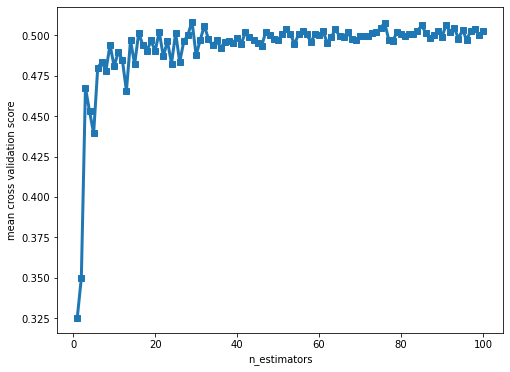

In [115]:
from sklearn.ensemble import RandomForestRegressor
scores = []
for i in range (1, 101):
    forest = RandomForestRegressor(n_estimators=i)
    #print('n_estimators =', i)
    #model_fitter(forest, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)
    #print ('-'*55, '\n')
    score = cross_val_score(forest, X_more_price_train, y_more_price_train, cv=5)
    scores.append(score.mean())
plt.figure(figsize=(8,6))
plt.plot(range(1,101), scores, lw=3, marker='s')
plt.xlabel('n_estimators')
plt.ylabel('mean cross validation score')
plt.show()

cv score converges at around 0.50

In [116]:
i_max = np.argmax(scores)+1
i_max

29

In [117]:
forest = RandomForestRegressor(n_estimators=i_max)
model_fitter(forest, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.49772672687446845
the training score is 0.7684005222013843
the test score is 0.5972462524966491


In [118]:
RMSE(forest, X_more_price, y_more_price)

180271.23068823433

In [119]:
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
base_estimator = DecisionTreeRegressor(max_depth = 7)
Ada = AdaBoostRegressor(base_estimator = base_estimator, n_estimators = 100, random_state = 42)
model_fitter(Ada, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.3907683994473204
the training score is 0.5391424116769945
the test score is 0.4632884366703093


In [120]:
RMSE(Ada, X_more_price, y_more_price)

312573.6404592957

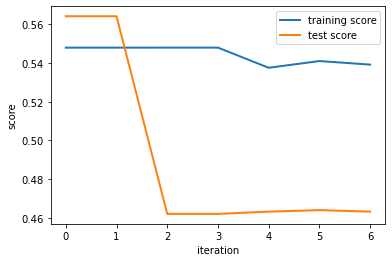

In [121]:
plt.plot(list(Ada.staged_score(X_more_price_train, y_more_price_train)),
         label='training score', lw=2)
plt.plot(list(Ada.staged_score(X_more_price_test, y_more_price_test)), label='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

In [122]:
Gboost = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    random_state=1)
model_fitter(Gboost, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.5316628271074635
the training score is 0.6683651490360947
the test score is 0.6309302127027112


In [123]:
RMSE(Gboost, X_more_price, y_more_price)

221939.62450240253

In [125]:
import statsmodels.api as sm
ols = sm.OLS(y_more_price.values.reshape(-1,1), sm.add_constant(X_more_price))
results = ols.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.553
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     111.7
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        09:13:58   Log-Likelihood:            -3.2117e+05
No. Observations:               41664   AIC:                         6.433e+05
Df Residuals:                   41207   BIC:                         6.472e+05
Df Model:                         456                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                        656.2262      3.368    194.814      0.000     649.624     662.828
pet_type_birds                             -7.946e+12   3.86e+13     -0.206      0.837   -8.35e+13    6.76e+13
pet_type_cats                              -1.709e+13   8.29e+13     -0.206      0.837    -1.8e+14    1.45e+14
pet_type_dogs                              -2.012e+13   9.76e+13     -0.206      0.837   -2.11e+14    1.71e+14
pet_type_fish                               -5.62e+12   2.73e+13     -0.206      0.837   -5.91e+13    4.78e+13
pet_type_horses                            -1.312e+14   1.27e+14     -1.031      0.303   -3.81e+14    1.18e+14
pet_type_invertebrates                     -3.212e+12   1.56e+13     -0.206      0.837   -3.38e+13    2.73e+13
pet_type_livestock                         -2.346e+12   1.14e+13     -0.206      0.837   -2.47e+13       2e+13
pet_type_poultry                           -6.802e+12    3.3e+13     -0.206      0.837   -7.15e+13    5.79e+13
pet_type_rabbits                            -1.13e+13   5.49e+13     -0.206      0.837   -1.19e+14    9.62e+13
pet_type_reptiles                          -7.872e+12   3.82e+13     -0.206      0.837   -8.28e+13     6.7e+13
pet_type_rodents                           -8.474e+12   4.11e+13     -0.206      0.837   -8.91e+13    7.21e+13
seller_type_Breeder                        -2.571e+13   7.81e+13     -0.329      0.742   -1.79e+14    1.27e+14
seller_type_Company                        -6.553e+11   1.99e+12     -0.329      0.742   -4.56e+12    3.25e+12
seller_type_Individual                     -2.661e+13   8.08e+13     -0.329      0.742   -1.85e+14    1.32e+14
seller_type_Licensed Breeder               -1.113e+13   3.38e+13     -0.329      0.742   -7.74e+13    5.51e+13
seller_type_Rescue/Charity                 -6.034e+12   1.83e+13     -0.329      0.742    -4.2e+13    2.99e+13
listing_type_adoption                       3.587e+12   1.06e+13      0.340      0.734   -1.71e+13    2.43e+13
listing_type_sale                           7.306e+12   2.15e+13      0.340      0.734   -3.48e+13    4.94e+13
listing_type_stud                            6.68e+12   1.97e+13      0.340      0.734   -3.18e+13    4.52e+13
species_Abyssinian                         -5.093e+11   2.64e+12     -0.193      0.847   -5.68e+12    4.66e+12
species_Aegean                             -3.092e+11    1.6e+12     -0.193      0.847   -3.45e+12    2.83e+12
species_Affenpinscher                      -1.169e+11   6.05e+11     -0.193      0.847    -1.3e+12    1.07e+12
species_Airedale Terrier                   -5.093e+11   2.64e+12     -0.193      0.847   -5.68e+12    4.66e+12
species_Akita                              -1.173e+12   6.07e+12     -0.193      0.847

In [126]:
#neural network
from sklearn.neural_network import MLPRegressor
nnet = MLPRegressor(hidden_layer_sizes=(4), solver='lbfgs',
                    activation='identity', max_iter=100000, 
                    alpha=10**(-12), 
                    random_state=1)
model_fitter(nnet, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)

the cv score is 0.5190056431272434
the training score is 0.5414743628386121
the test score is 0.5733010561419972


In [127]:
RMSE(nnet, X_more_price, y_more_price)

292288.1760534287

Will we get better result if we separate dogs from the others? Dogs makes up roughly half of our data and has third highest variance. Lifestock and horses have higher variance but there are so few of them compared with dogs.

# Dogs only

## Filtering the data

In [195]:
dogs = df_clean.loc[df_clean['pet_type'] == 'dogs'].reset_index(drop=True)
dogs

Title   price  \
0                                  Gorgeous JR for stud    350.0   
1      ABKC XL American Bully available for stud duties   2000.0   
2                   Male Staffordshire Bull Terrier stud   123.0   
3                      Long coat German Shepard for stud   300.0   
4                                      Stud at kennel s    500.0   
...                                                  ...     ...   
20260                        gorgeous retriever for stud   250.0   
20261                        PROVEN Fox Red Lab for stud   120.0   
20262               * At Stud KC Health tested Labrador*   350.0   
20263     **Beautiful KC Reg White Pug For Stud Proven**   100.0   
20264          stunning fox red labrador for stud proven   150.0   

                          species        age   gender  \
0                    Jack Russell  11 months  unknown   
1                  American Bully     1 year  unknown   
2      Staffordshire Bull Terrier    8 years  unknown   
3                 German Shepherd    2 years  unknown   
4              Labrador Retriever    2 years  unknown   
...                           ...        ...      ...   
20260            Golden Retriever    8 years  unknown   
20261          Labrador Retriever    3 years  unknown   
20262          Labrador Retriever    3 years  unknown   
20263                         Pug    5 years  unknown   
20264          Labrador Retriever    8 years  unknown   

                                             description       seller_name  \
0      Rusty is a Black and Tan full jack russell wit...            Meg M.   
1      Duke is now at his LAST stud booking before we...       Jennifer P.   
2      Beautiful black and white Staffordshire Bull T...      Katarzyna J.   
3      Beautiful, experienced and the best dog for st...          Agata R.   
4      Palmlove Labradors breeders   Licensed under A...         Robert p.   
...                                                  ...               ...   
20260  Stanley our chunky gentle giant available for ...        richard h.   
20261  Gorgeous family Loving boy for stud only, he g...         Debbie w.   
20262  Reuben (Milebushfarm Quest) is a loyal and kin...  BROWFARM GUNDOGS   
20263  'Brandarsaig Do It Like A Dude' aka Hamish is ...           Maryann   
20264  i have for stud my labrador hes a beautiful fo...           joan B.   

      seller_location seller_type listing_type pet_type      year  
0            Aberdeen     Breeder         stud     dogs  0.916667  
1           Peterhead  Individual         stud     dogs  1.000000  
2            Westhill  Individual         stud     dogs  8.000000  
3            Westhill  Individual         stud     dogs  2.000000  
4           Peterhead  Individual         stud     dogs  2.000000  
...               ...         ...          ...      ...       ...  
20260           Leeds  Individual         stud     dogs  8.000000  
20261      Pontefract     Breeder         stud     dogs  3.000000  
20262          Malton     Breeder         stud     dogs  3.000000  
20263        Birstall     Breeder         stud     dogs  5.000000  
20264      Castleford  Individual         stud     dogs  8.000000  

[20265 rows x 12 columns]

## Predict if the dog is expensive or affordable

We will repeat the process like in previous section, except this time we only have dogs in our dataset.

In [197]:
dogs.describe()

price          year
count  20265.000000  20265.000000
mean    1061.715223      1.166694
std      891.341279      1.796427
min        0.000000      0.000000
25%      450.000000      0.153846
50%      900.000000      0.250000
75%     1500.000000      2.000000
max    22000.000000     24.000000

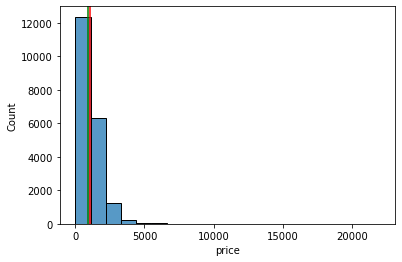

In [199]:
ax = sns.histplot(dogs['price'], bins=20)
ax.axvline(dogs['price'].mean(), c='r')
ax.axvline(dogs['price'].median(), c='g')

In [200]:
median_price_dog = np.median(dogs.price)
median_price_dog

900.0

In [198]:
dogs.nunique()

Title              17800
price                274
species              191
age                   67
gender                 4
description        19084
seller_name        11871
seller_location      914
seller_type            5
listing_type           3
pet_type               1
year                  50
dtype: int64

In [201]:
dogs['price_class'] = [1 if i > median_price_dog else 0 for i in dogs.price]

In [202]:
dogs.price_class.value_counts()

0    10283
1     9982
Name: price_class, dtype: int64

And the baseline accuracy is

In [203]:
dogs.price_class.value_counts(normalize=True)

0    0.507427
1    0.492573
Name: price_class, dtype: float64

### Create Classification models

In [204]:
X_dogs = pd.get_dummies(dogs[['seller_type','listing_type', 'species' , 'gender']])
X_dogs = pd.DataFrame(scaler.fit_transform(X_dogs), columns=X_dogs.columns)
y_dogs = dogs.price_class
X_dogs_train, X_dogs_test, y_dogs_train, y_dogs_test = train_test_split(X_dogs,
                                                    y_dogs, test_size=0.3, random_state=8)

In [205]:
log_dogs = LogisticRegression(penalty='none', max_iter=1000)
model_fitter(log_dogs, X_dogs_train, y_dogs_train, X_dogs_test, y_dogs_test)

the cv score is 0.8142403947832217
the training score is 0.8184702150158618
the test score is 0.8199013157894737


In [206]:
RMSE(log_dogs, X_dogs, y_dogs)

0.18110041944238836

In [139]:
knn_dogs = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn_dogs, X_dogs_train, y_dogs_train, X_dogs_test, y_dogs_test)

the cv score is 0.7749030666196687
the training score is 0.7859005992245329
the test score is 0.7779605263157895


In [140]:
RMSE(knn_dogs, X_dogs, y_dogs)

0.2164816185541574

### NLP models to predict high or low

In [207]:
dogs_text = dogs
dogs_text['text'] = dogs_text.apply(combine_text, axis=1)
dogs_text['text'] = dogs_text['text'].apply(clean_text)
dogs_text['text'] = dogs_text['text'].apply(standardize)
dogs_text

Title   price  \
0                                  Gorgeous JR for stud    350.0   
1      ABKC XL American Bully available for stud duties   2000.0   
2                   Male Staffordshire Bull Terrier stud   123.0   
3                      Long coat German Shepard for stud   300.0   
4                                      Stud at kennel s    500.0   
...                                                  ...     ...   
20260                        gorgeous retriever for stud   250.0   
20261                        PROVEN Fox Red Lab for stud   120.0   
20262               * At Stud KC Health tested Labrador*   350.0   
20263     **Beautiful KC Reg White Pug For Stud Proven**   100.0   
20264          stunning fox red labrador for stud proven   150.0   

                          species        age   gender  \
0                    Jack Russell  11 months  unknown   
1                  American Bully     1 year  unknown   
2      Staffordshire Bull Terrier    8 years  unknown   
3                 German Shepherd    2 years  unknown   
4              Labrador Retriever    2 years  unknown   
...                           ...        ...      ...   
20260            Golden Retriever    8 years  unknown   
20261          Labrador Retriever    3 years  unknown   
20262          Labrador Retriever    3 years  unknown   
20263                         Pug    5 years  unknown   
20264          Labrador Retriever    8 years  unknown   

                                             description       seller_name  \
0      Rusty is a Black and Tan full jack russell wit...            Meg M.   
1      Duke is now at his LAST stud booking before we...       Jennifer P.   
2      Beautiful black and white Staffordshire Bull T...      Katarzyna J.   
3      Beautiful, experienced and the best dog for st...          Agata R.   
4      Palmlove Labradors breeders   Licensed under A...         Robert p.   
...                                                  ...               ...   
20260  Stanley our chunky gentle giant available for ...        richard h.   
20261  Gorgeous family Loving boy for stud only, he g...         Debbie w.   
20262  Reuben (Milebushfarm Quest) is a loyal and kin...  BROWFARM GUNDOGS   
20263  'Brandarsaig Do It Like A Dude' aka Hamish is ...           Maryann   
20264  i have for stud my labrador hes a beautiful fo...           joan B.   

      seller_location seller_type listing_type pet_type      year  \
0            Aberdeen     Breeder         stud     dogs  0.916667   
1           Peterhead  Individual         stud     dogs  1.000000   
2            Westhill  Individual         stud     dogs  8.000000   
3            Westhill  Individual         stud     dogs  2.000000   
4           Peterhead  Individual         stud     dogs  2.000000   
...               ...         ...          ...      ...       ...   
20260           Leeds  Individual         stud     dogs  8.000000   
20261      Pontefract     Breeder         stud     dogs  3.000000   
20262          Malton     Breeder         stud     dogs  3.000000   
20263        Birstall     Breeder         stud     dogs  5.000000   
20264      Castleford  Individual         stud     dogs  8.000000   

       price_class                                               text  
0                0  aberdeen gorgeous jr for stud rusty is a black...  
1                1  peterhead abkc xl american bully available for...  
2                0  westhill male staffordshire bull terrier stud ...  
3                0  westhill long coat german shepard for stud bea...  
4                0  peterhead stud at kennel s palmlove labradors ...  
...            ...                                                ...  
20260            0  leeds gorgeous retriever for stud stanley our ...  
20261            0  pontefract proven fox red lab for stud gorgeou...  
20262            0  malton at stud kc health tested labrador reube...  
20263            0  birstall beautiful kc reg white pug for stu

In [208]:
vectorizer.fit(dogs_text.text)
text_vec = vectorizer.transform(dogs_text.text)
text_vec

<20265x17610 sparse matrix of type '<class 'numpy.float64'>'
	with 463999 stored elements in Compressed Sparse Row format>

In [209]:
# convert the text_vec to dataframe
df  = pd.DataFrame(text_vec.todense(),
                   columns = vectorizer.get_feature_names())

df.transpose().head(50).transpose()

aa  aare   ab  aba  abandoned  abbadoocockerspaniels  abbb  abbey  \
0      0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
1      0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
2      0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
3      0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
4      0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
...    ...   ...  ...  ...        ...                    ...   ...    ...   
20260  0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
20261  0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
20262  0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
20263  0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   
20264  0.0   0.0  0.0  0.0        0.0                    0.0   0.0    0.0   

       abbie  abbot  ...  aboo  aborable  abou  aboyne  abr  abra  abro  \
0        0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
1        0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
2        0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
3        0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
4        0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
...      ...    ...  ...   ...       ...   ...     ...  ...   ...   ...   
20260    0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
20261    0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
20262    0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
20263    0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   
20264    0.0    0.0  ...   0.0       0.0   0.0     0.0  0.0   0.0   0.0   

       abroad  abs  absalutly  
0         0.0  0.0        0.0  
1         0.0  0.0        0.0  
2         0.0  0.0        0.0  
3         0.0  0.0        0.0  
4         0.0  0.0        0.0  
...       ...  ...        ...  
20260     0.0  0.0        0.0  
20261     0.0  0.0        0.0  
20262     0.0  0.0        0.0  
20263     0.0  0.0        0.0  
20264     0.0  0.0        0.0  

[20265 rows x 50 columns]

In [210]:
#train test split for nlp featured models
X_nlp_dogs = df
X_nlp_train_dogs, X_nlp_test_dogs, y_nlp_train_dogs, y_nlp_test_dogs = train_test_split(X_nlp_dogs,
                                                    y_dogs, test_size=0.3, random_state=8)

In [212]:
dtc_dogs = DecisionTreeClassifier(max_depth=15)
model_fitter(dtc_dogs, X_nlp_train_dogs, y_nlp_train_dogs, X_nlp_test_dogs, y_nlp_test_dogs)

the cv score is 0.7672188931970392
the training score is 0.8468100105745506
the test score is 0.7639802631578947


In [213]:
RMSE(dtc_dogs, X_nlp_dogs, y_dogs)

0.1780409573155687

In [214]:
bagger_dtc_dogs = BaggingClassifier(base_estimator = dtc, max_samples=1.)
model_fitter(bagger_dtc_dogs, X_nlp_train_dogs, y_nlp_train_dogs, X_nlp_test_dogs, y_nlp_test_dogs)

the cv score is 0.7826577370461754
the training score is 0.8670426506873458
the test score is 0.7837171052631579


In [146]:
y_dogs

31       0
32       1
33       0
34       0
35       0
        ..
41633    0
41634    0
41635    0
41636    0
41637    0
Name: price_class, Length: 20265, dtype: int64

In [215]:
RMSE(bagger_dtc_dogs, X_nlp_dogs, y_dogs)

0.15795706883789784

In [216]:
random_forest_dtc_dogs = RandomForestClassifier(max_depth=None, n_estimators=10, max_features = 300)
model_fitter(random_forest_dtc_dogs, X_nlp_train_dogs, y_nlp_train_dogs, X_nlp_test_dogs, y_nlp_test_dogs)

the cv score is 0.7870990482904476
the training score is 0.9911173775114558
the test score is 0.8050986842105263


In [217]:
RMSE(random_forest_dtc_dogs, X_nlp_dogs, y_dogs)

0.06469282013323464

In [220]:
# set up parameter for gridsearchCV
# this takes pretty long, go grab some coffee
dtc_params = {
    'max_depth':[None, 5,10,15,20],
    'max_features':[None, 50, 100, 200, 300],
    'min_samples_split':[10,15,20,25,30]
}
dtc_gs_dogs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)
model_fitter(dtc_gs_dogs, X_nlp_train_dogs, y_nlp_train_dogs, X_nlp_test_dogs, y_nlp_test_dogs)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
the cv score is 0.7642580190341911
the training score is 0.8391963341557984
the test score is 0.7623355263157895


In [221]:
RMSE(dtc_gs_dogs, X_nlp_dogs, y_dogs)

0.18386380458919319

### Model accuracy

In [222]:
model_accuracy(log_dogs, X_dogs, y_dogs)

LogisticRegression(max_iter=1000, penalty='none')
accuracy score is 0.8188995805576117
auc score is 0.8200369923861589
------------------------------------------------------- 

the confusion matrix is:
 [[7645 2638]
 [1032 8950]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.88      0.74      0.81     10283
higher price       0.77      0.90      0.83      9982

    accuracy                           0.82     20265
   macro avg       0.83      0.82      0.82     20265
weighted avg       0.83      0.82      0.82     20265



In [223]:
model_accuracy(knn_dogs, X_dogs, y_dogs)

KNeighborsClassifier()
accuracy score is 0.7835183814458426
auc score is 0.7836443583474079
------------------------------------------------------- 

the confusion matrix is:
 [[7971 2312]
 [2075 7907]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.79      0.78      0.78     10283
higher price       0.77      0.79      0.78      9982

    accuracy                           0.78     20265
   macro avg       0.78      0.78      0.78     20265
weighted avg       0.78      0.78      0.78     20265



In [224]:
model_accuracy(dtc_dogs, X_nlp_dogs, y_dogs)

DecisionTreeClassifier(max_depth=15)
accuracy score is 0.8219590426844313
auc score is 0.8224270671551883
------------------------------------------------------- 

the confusion matrix is:
 [[8133 2150]
 [1458 8524]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.85      0.79      0.82     10283
higher price       0.80      0.85      0.83      9982

    accuracy                           0.82     20265
   macro avg       0.82      0.82      0.82     20265
weighted avg       0.82      0.82      0.82     20265



In [225]:
model_accuracy(bagger_dtc_dogs, X_nlp_dogs, y_dogs)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
accuracy score is 0.8420429311621022
auc score is 0.8426671412217963
------------------------------------------------------- 

the confusion matrix is:
 [[8233 2050]
 [1151 8831]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.88      0.80      0.84     10283
higher price       0.81      0.88      0.85      9982

    accuracy                           0.84     20265
   macro avg       0.84      0.84      0.84     20265
weighted avg       0.84      0.84      0.84     20265



In [226]:
model_accuracy(random_forest_dtc_dogs, X_nlp_dogs, y_dogs)

RandomForestClassifier(max_features=300, n_estimators=10)
accuracy score is 0.9353071798667654
auc score is 0.9353009685643825
------------------------------------------------------- 

the confusion matrix is:
 [[9622  661]
 [ 650 9332]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.94      0.94      0.94     10283
higher price       0.93      0.93      0.93      9982

    accuracy                           0.94     20265
   macro avg       0.94      0.94      0.94     20265
weighted avg       0.94      0.94      0.94     20265



In [227]:
model_accuracy(dtc_gs_dogs, X_nlp_dogs, y_dogs)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'max_features': [None, 50, 100, 200, 300],
                         'min_samples_split': [10, 15, 20, 25, 30]},
             verbose=1)
accuracy score is 0.8161361954108068
auc score is 0.816592671437587
------------------------------------------------------- 

the confusion matrix is:
 [[8081 2202]
 [1524 8458]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.84      0.79      0.81     10283
higher price       0.79      0.85      0.82      9982

    accuracy                           0.82     20265
   macro avg       0.82      0.82      0.82     20265
weighted avg       0.82      0.82      0.82     20265



## Price Prediction

In [230]:
#dummify and train test split
X_more_price_dogs = pd.get_dummies(dogs[['seller_type','listing_type', 'species' , 'gender']])
X_more_price_dogs['year'] = dogs['year']
X_more_price_dogs = pd.DataFrame(scaler.fit_transform(X_more_price_dogs), columns=X_more_price_dogs.columns)
y_more_price_dogs = dogs.price
X_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_train, y_more_price_dogs_test = train_test_split(
    X_more_price_dogs, y_more_price_dogs, test_size=0.3, random_state=8)

In [231]:
#linear regression
linreg_dogs = LinearRegression()
model_fitter(linreg_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is -1.6378215561511083e+27
the training score is 0.3649763717526534
the test score is -6.56908290435888e+25


In [240]:
RMSE(linreg_dogs, X_more_price_dogs, y_more_price_dogs)

1.3943135136869043e+31

In [233]:
#Ridge regression
# Find an optimal value for Ridge regression alpha using RidgeCV
optimal_ridge_dogs = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge_dogs.fit( X_more_price_dogs_train, y_more_price_dogs_train)

print(optimal_ridge_dogs.alpha_)

488.02515836544336


In [236]:
ridge_dogs = Ridge(alpha=optimal_ridge_dogs.alpha_)
model_fitter(ridge_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.36572695566832564
the training score is 0.36484014101663287
the test score is 0.43624835101357806


In [241]:
RMSE(ridge_dogs, X_more_price_dogs, y_more_price_dogs)

489445.3504620076

In [235]:
#Lasso
optimal_lasso_dogs = LassoCV(n_alphas= 3000, cv=10, verbose=1)
optimal_lasso_dogs.fit(X_more_price_dogs_train, y_more_price_dogs_train)
clear_output(wait=True)
print(optimal_lasso_dogs.alpha_)

1.5963054900289888


In [237]:
lasso_dogs = Lasso(alpha=optimal_lasso_dogs.alpha_)
clear_output(wait=True)
model_fitter(lasso_dogs,  X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.36599877497114514
the training score is 0.36465933263790606
the test score is 0.43676803263124586


In [242]:
RMSE(lasso_dogs, X_more_price_dogs, y_more_price_dogs)

489440.3117325277

In [238]:
optimal_elastic_dogs = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100), cv=5)
optimal_elastic_dogs.fit( X_more_price_dogs_train, y_more_price_dogs_train)
clear_output(wait=True)
print(optimal_elastic_dogs.alpha_)
print(optimal_elastic_dogs.l1_ratio_)

1.4174741629268048
0.99


In [239]:
elastic_dogs = ElasticNet(alpha=optimal_elastic_dogs.alpha_, l1_ratio=optimal_elastic_dogs.l1_ratio_)
model_fitter(elastic_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.3661667051768921
the training score is 0.3645746979669249
the test score is 0.436587685628846


In [243]:
RMSE(elastic_dogs, X_more_price_dogs, y_more_price_dogs)

489527.86496621167

In [244]:
tree_dogs = DecisionTreeRegressor(max_depth = 6, max_features = 0.7) #adjust this
model_fitter(tree_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.32012757192481567
the training score is 0.3958848521116286
the test score is 0.20491922368465554


In [245]:
RMSE(tree_dogs, X_more_price_dogs, y_more_price_dogs)

520471.78768446634

In [246]:
bagger_tree_dogs = BaggingRegressor(base_estimator = tree, n_estimators = 100, random_state = 7)
model_fitter(bagger_tree_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.3481304115715217
the training score is 0.3966028969551787
the test score is 0.41367049105692144


In [247]:
RMSE(bagger_tree_dogs, X_more_price_dogs, y_more_price_dogs)

475745.4734559535

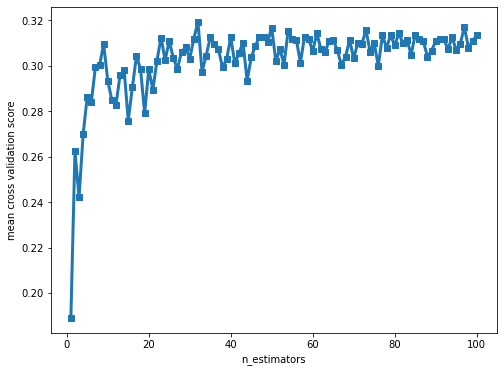

In [248]:
scores_dogs = []
for i in range (1, 101):
    forest_dogs = RandomForestRegressor(n_estimators=i)
    #print('n_estimators =', i)
    #model_fitter(forest, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)
    #print ('-'*55, '\n')
    score = cross_val_score(forest_dogs, X_more_price_dogs_train, y_more_price_dogs_train, cv=5)
    scores_dogs.append(score.mean())
plt.figure(figsize=(8,6))
plt.plot(range(1,101), scores_dogs, lw=3, marker='s')
plt.xlabel('n_estimators')
plt.ylabel('mean cross validation score')
plt.show()

In [249]:
i_max_dogs = np.argmax(scores_dogs)+1
i_max_dogs

32

In [250]:
forest_dogs = RandomForestRegressor(n_estimators=i_max_dogs)
model_fitter(forest_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.2989360623029004
the training score is 0.6682048097140685
the test score is 0.36471113436631586


In [251]:
RMSE(forest_dogs, X_more_price_dogs, y_more_price_dogs)

328012.0270963203

In [252]:
base_estimator = DecisionTreeRegressor(max_depth = 7)
Ada_dogs = AdaBoostRegressor(base_estimator = base_estimator, n_estimators = 100, random_state = 42)
model_fitter(Ada_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.1855568664582719
the training score is 0.3549955307136776
the test score is 0.06342019964680456


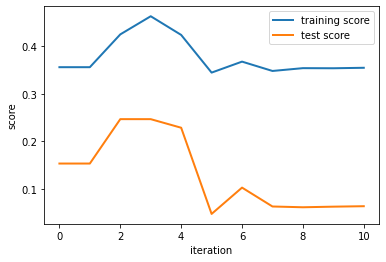

In [253]:
plt.plot(list(Ada_dogs.staged_score(X_more_price_dogs_train, y_more_price_dogs_train)),
         label='training score', lw=2)
plt.plot(list(Ada_dogs.staged_score(X_more_price_dogs_test, y_more_price_dogs_test)), label='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

In [254]:
RMSE(Ada_dogs, X_more_price_dogs, y_more_price_dogs)

574311.0647033938

In [256]:
Gboost_dogs = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    random_state=1)
model_fitter(Gboost_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.3697957086680038
the training score is 0.5444517906970703
the test score is 0.4198613958529571


In [257]:
RMSE(Gboost_dogs, X_more_price_dogs, y_more_price_dogs)

388354.550915622

In [258]:
ols_dogs = sm.OLS(y_more_price_dogs, sm.add_constant(X_more_price_dogs))
results = ols_dogs.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.380
Method:                 Least Squares   F-statistic:                     63.02
Date:                Wed, 22 Jun 2022   Prob (F-statistic):               0.00
Time:                        16:13:01   Log-Likelihood:            -1.6147e+05
No. Observations:               20265   AIC:                         3.233e+05
Df Residuals:                   20064   BIC:                         3.249e+05
Df Model:                         200                                         
Covariance Type:            nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const                                       1060.0780      6.481    163.564      0.000    1047.375    1072.782
seller_type_Breeder                        -4.711e+14   3.15e+14     -1.494      0.135   -1.09e+15    1.47e+14
seller_type_Company                        -1.285e+13    8.6e+12     -1.494      0.135   -2.97e+13    4.01e+12
seller_type_Individual                     -5.073e+14    3.4e+14     -1.494      0.135   -1.17e+15    1.58e+14
seller_type_Licensed Breeder               -2.675e+14   1.79e+14     -1.494      0.135   -6.18e+14    8.34e+13
seller_type_Rescue/Charity                 -1.399e+14   9.36e+13     -1.494      0.135   -3.23e+14    4.36e+13
listing_type_adoption                        9.61e+13   2.01e+14      0.479      0.632   -2.97e+14    4.89e+14
listing_type_sale                           2.483e+14   5.18e+14      0.479      0.632   -7.67e+14    1.26e+15
listing_type_stud                           2.401e+14   5.01e+14      0.479      0.632   -7.42e+14    1.22e+15
species_Affenpinscher                       -4.84e+11    3.4e+12     -0.142      0.887   -7.15e+12    6.18e+12
species_Airedale Terrier                   -2.109e+12   1.48e+13     -0.142      0.887   -3.11e+13    2.69e+13
species_Akita                              -4.853e+12   3.41e+13     -0.142      0.887   -7.16e+13    6.19e+13
species_Alapaha Blue Blood Bulldog         -2.605e+12   1.83e+13     -0.142      0.887   -3.85e+13    3.32e+13
species_Alaskan Malamute                   -2.778e+12   1.95e+13     -0.142      0.887    -4.1e+13    3.55e+13
species_American Bulldog                   -5.605e+12   3.94e+13     -0.142      0.887   -8.28e+13    7.15e+13
species_American Bully                     -1.434e+13   1.01e+14     -0.142      0.887   -2.12e+14    1.83e+14
species_American Cocker Spaniel            -1.605e+12   1.13e+13     -0.142      0.887   -2.37e+13    2.05e+13
species_Anatolian Shepherd                 -6.845e+11   4.81e+12     -0.142      0.887   -1.01e+13    8.74e+12
species_Australian Cattle Dog              -6.845e+11   4.81e+12     -0.142      0.887   -1.01e+13    8.74e+12
species_Australian Kelpie                  -1.452e+12   1.02e+13     -0.142      0.887   -2.14e+13    1.85e+13
species_Australian Shepherd                -8.384e+11   5.89e+12     -0.142      0.887   -1.24e+13    1.07e+13
species_Australian Silky Terrier            -4.84e+11    3.4e+12     -0.142      0.887   -7.15e+12    6.18e+12
species_Basset Hound                       -2.053e+12   1.44e+13     -0.142      0.887   -3.03e+13    2.62e+13
species_Bavarian Mountain Hound             -4.84e+11    3.4e+12     -0.142      0.887   -7.15e+12    6.18e+12
species_Beagle                             -5.086e+12   3.57e+13     -0.142      0.887

In [259]:
nnet_dogs = MLPRegressor(hidden_layer_sizes=(4), solver='lbfgs',
                    activation='identity', max_iter=100000, 
                    alpha=10**(-12), 
                    random_state=1)
model_fitter(nnet_dogs, X_more_price_dogs_train, y_more_price_dogs_train, X_more_price_dogs_test, y_more_price_dogs_test)

the cv score is 0.3623905748734906
the training score is 0.3651762915459634
the test score is 0.43398465671299224


In [260]:
RMSE(nnet_dogs, X_more_price_dogs, y_more_price_dogs)

489730.1232826932

# No Dogs

## Filtering the data

In [261]:
no_dogs = df_clean.loc[df_clean['pet_type'] != 'dogs'].reset_index(drop=True)
no_dogs

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
21394      canarys for sale all colour plus new colours    40.0      Canaries   
21395  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
21396                Hand reared indian ringnecks babys   350.0       Parrots   
21397                    One yellow one orange canary.     60.0      Canaries   
21398                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
21394   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
21395   4 years    Male  Rainbow is a beautiful example of a blue and g...   
21396    1 year    Male  Hand reared cuddly silly tame little babys for...   
21397   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
21398   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
21394             Robert n.     Knottingley           Breeder         sale   
21395  The Bradford Birdman        Bradford  Licensed Breeder         sale   
21396              Waqar A.        Bradford           Breeder         sale   
21397             Amylia R.        Barnsley        Individual         sale   
21398              Ahmad R.        Bradford           Breeder         sale   

       pet_type      year  
0      reptiles  3.000000  
1      reptiles  1.000000  
2      reptiles  4.000000  
3      reptiles  0.750000  
4         birds  0.173077  
...         ...       ...  
21394     birds  0.134615  
21395     birds  4.000000  
21396     birds  1.000000  
21397     birds  2.000000  
21398     birds  9.000000  

[21399 rows x 12 columns]

## Predict if the pet is expensive or affordable

Like before, we will repeat the process in the previous section, except this time we remove dogs from our dataset.

In [262]:
no_dogs.describe()

price          year
count  21399.000000  21399.000000
mean     273.210758      0.738007
std      458.193574      1.622977
min        0.000000      0.000000
25%       40.000000      0.153846
50%      100.000000      0.230769
75%      300.000000      0.750000
max    12000.000000     66.000000

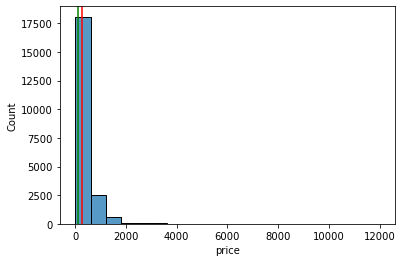

In [263]:
ax = sns.histplot(no_dogs['price'], bins=20)
ax.axvline(no_dogs['price'].mean(), c='r')
ax.axvline(no_dogs['price'].median(), c='g')

In [264]:
median_price_no_dogs = np.median(no_dogs.price)
median_price_no_dogs

100.0

In [265]:
no_dogs['price_class'] = [1 if i > median_price_no_dogs else 0 for i in no_dogs.price]

In [266]:
no_dogs.price_class.value_counts()

0    11354
1    10045
Name: price_class, dtype: int64

In [267]:
no_dogs.price_class.value_counts(normalize=True)

0    0.530586
1    0.469414
Name: price_class, dtype: float64

### Create a classification model to predict High/Low price.

In [268]:
#dummify and train test split
X_no_dogs = pd.get_dummies(no_dogs[['pet_type']])
X_no_dogs = pd.DataFrame(scaler.fit_transform(X_no_dogs), columns=X_no_dogs.columns)
y_no_dogs = no_dogs.price_class
X_no_dogs_train, X_no_dogs_test, y_no_dogs_train, y_no_dogs_test = train_test_split(X_no_dogs,
                                                    y_no_dogs, test_size=0.3, random_state=8)
log_no_dogs = LogisticRegression()
model_fitter(log_no_dogs, X_no_dogs_train, y_no_dogs_train, X_no_dogs_test, y_no_dogs_test)

the cv score is 0.7914409864237458
the training score is 0.7914413512250484
the test score is 0.7989096573208723


In [270]:
RMSE(log_no_dogs, X_no_dogs, y_no_dogs)

0.20631805224543204

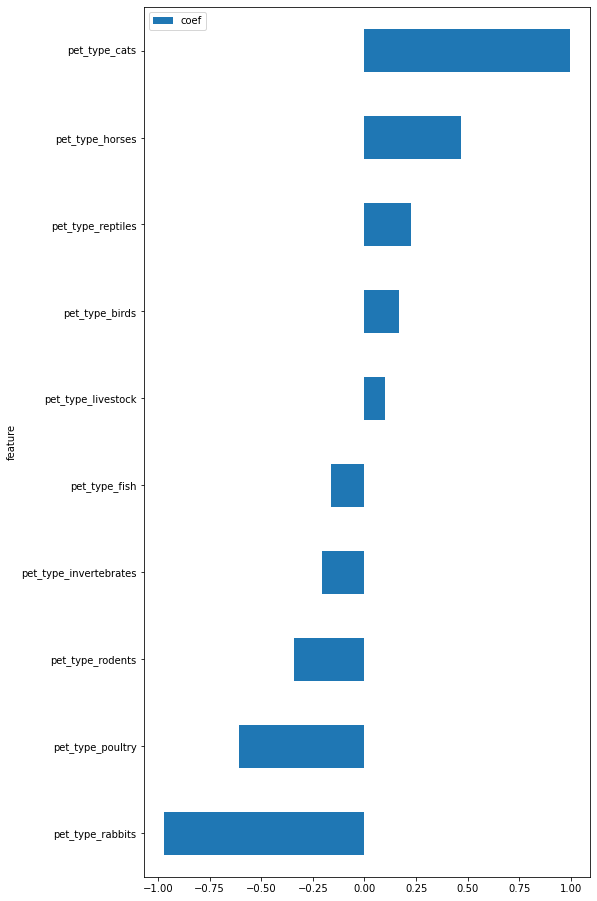

In [269]:
pd.DataFrame(list(zip(X_no_dogs.columns, log_no_dogs.coef_[0])), 
             columns=['feature', 'coef'])\
    .sort_values(by='coef') \
    .plot(kind='barh', x='feature', y='coef', figsize=(8, 16))
plt.show()

In [271]:
knn_no_dogs = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn_no_dogs, X_no_dogs_train, y_no_dogs_train, X_no_dogs_test, y_no_dogs_test)

the cv score is 0.7864344000124819
the training score is 0.7889044662527539
the test score is 0.799221183800623


In [272]:
RMSE(knn_no_dogs, X_no_dogs, y_no_dogs)

0.2080003738492453

In [273]:
#dummify and train test split
X_more_no_dogs = pd.get_dummies(no_dogs[['pet_type','seller_type','listing_type', 'species' , 'gender']])
X_more_no_dogs = pd.DataFrame(scaler.fit_transform(X_more_no_dogs), columns=X_more_no_dogs.columns)
y_more_no_dogs = no_dogs.price_class
X_more_no_dogs_train, X_more_no_dogs_test, y_more_no_dogs_train, y_more_no_dogs_test = train_test_split(X_more_no_dogs,
                                                    y_more_no_dogs, test_size=0.3, random_state=8)

In [274]:
log_more_no_dogs = LogisticRegression(penalty='none', max_iter=1000)
model_fitter(log_more_no_dogs, X_more_no_dogs_train, y_more_no_dogs_train, X_more_no_dogs_test, y_more_no_dogs_test)

the cv score is 0.8358366971209247
the training score is 0.8403097670071433
the test score is 0.846417445482866


In [275]:
RMSE(log_more_no_dogs, X_more_no_dogs, y_more_no_dogs)

0.1578578438244778

In [276]:
knn_more_no_dogs = KNeighborsClassifier(n_neighbors=5)
model_fitter(knn_more_no_dogs, X_more_no_dogs_train, y_more_no_dogs_train, X_more_no_dogs_test, y_more_no_dogs_test)

the cv score is 0.8178112831577329
the training score is 0.838106682689098
the test score is 0.8274143302180685


In [277]:
RMSE(knn_more_no_dogs, X_more_no_dogs, y_more_no_dogs)

0.1651011729520071

### NLP models to predict high or low

In [278]:
no_dogs_text = no_dogs
no_dogs_text['text'] = no_dogs_text.apply(combine_text, axis=1)
no_dogs_text['text'] = no_dogs_text['text'].apply(clean_text)
no_dogs_text['text'] = no_dogs_text['text'].apply(standardize)
no_dogs_text

Title   price       species  \
0              unsexed green tree python + 60cm vivtek   1000.0  Python Snake   
1                                     Leopard gecko (f)    80.0         Gecko   
2                                                  rexy   100.0        Iguana   
3                    Panther Chameleon and full set up    550.0     Chameleon   
4                   Hand reared white Indian ringnecks    300.0     Parakeets   
...                                                 ...     ...           ...   
21394      canarys for sale all colour plus new colours    40.0      Canaries   
21395  TAME & TALKING HARNESS TRAINED BLUE & GOLD MACAW  2150.0        Macaws   
21396                Hand reared indian ringnecks babys   350.0       Parrots   
21397                    One yellow one orange canary.     60.0      Canaries   
21398                     Tame and talking African grey  1250.0       Parrots   

            age  gender                                        description  \
0       3 years   Mixed  ~3years old gtp biak x sorong    Typical gtp a...   
1        1 year  Female  Selling this leopard gecko I've had the joy of...   
2       4 years    Male  rexy needs a new home ASP   sadly I don't not ...   
3      9 months    Male  Blue is a 6 month old Nosey Mitsio chameleon. ...   
4       9 weeks   Mixed  I have 2 stunning white Indian ringnecks. 1 ma...   
...         ...     ...                                                ...   
21394   7 weeks   Mixed  there are all mixed cocks and hens new volour ...   
21395   4 years    Male  Rainbow is a beautiful example of a blue and g...   
21396    1 year    Male  Hand reared cuddly silly tame little babys for...   
21397   2 years   Mixed  I’m reluctantly listing my canaries (peach and...   
21398   9 years    Male  Pablo has just turned 9 not able to give him t...   

                seller_name seller_location       seller_type listing_type  \
0                 Patryk M.        Aberdeen        Individual         sale   
1                   Dana I.        Aberdeen        Individual         sale   
2                Gillian W.        Aberdeen        Individual         sale   
3                  Craig H.        Aberdeen        Individual         sale   
4                   Dave T.        Aberdeen        Individual         sale   
...                     ...             ...               ...          ...   
21394             Robert n.     Knottingley           Breeder         sale   
21395  The Bradford Birdman        Bradford  Licensed Breeder         sale   
21396              Waqar A.        Bradford           Breeder         sale   
21397             Amylia R.        Barnsley        Individual         sale   
21398              Ahmad R.        Bradford           Breeder         sale   

       pet_type      year  price_class  \
0      reptiles  3.000000            1   
1      reptiles  1.000000            0   
2      reptiles  4.000000            0   
3      reptiles  0.750000            1   
4         birds  0.173077            1   
...         ...       ...          ...   
21394     birds  0.134615            0   
21395     birds  4.000000            1   
21396     birds  1.000000            1   
21397     birds  2.000000            0   
21398     birds  9.000000            1   

                                                    text  
0      aberdeen unsexed green tree python cm vivtek y...  
1      aberdeen leopard gecko f selling this leopard ...  
2      aberdeen rexy rexy needs a new home as soon as...  
3      aberdeen panther chameleon and full set up blu...  
4      aberdeen hand reared white indian ringnecks i ...  
...                                                  ...  
21394  knottingley canary for sale all colour plus ne...  
21395  bradford tame talking harness trained blue gol...  
21396  bradford hand reared indian ringnecks baby han...  
21397  barnsley one yellow one orange canary i m relu...  
21398  bradford tame and talking african grey pab

In [279]:
vectorizer.fit(no_dogs_text.text)
text_vec = vectorizer.transform(no_dogs_text.text)
text_vec

<21399x16184 sparse matrix of type '<class 'numpy.float64'>'
	with 417566 stored elements in Compressed Sparse Row format>

In [280]:
# convert the text_vec to dataframe
df  = pd.DataFrame(text_vec.todense(),
                   columns = vectorizer.get_feature_names())

df.transpose().head(50).transpose()

aa  aaa  aal  aardeens  aarden   ab  abacot  abandoned  abbey  abbit  \
0      0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
1      0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
2      0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
3      0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
4      0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
...    ...  ...  ...       ...     ...  ...     ...        ...    ...    ...   
21394  0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
21395  0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
21396  0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
21397  0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   
21398  0.0  0.0  0.0       0.0     0.0  0.0     0.0        0.0    0.0    0.0   

       ...  absolutley  absolutly  absorb  absoulutely  abundance  abused  \
0      ...         0.0        0.0     0.0          0.0        0.0     0.0   
1      ...         0.0        0.0     0.0          0.0        0.0     0.0   
2      ...         0.0        0.0     0.0          0.0        0.0     0.0   
3      ...         0.0        0.0     0.0          0.0        0.0     0.0   
4      ...         0.0        0.0     0.0          0.0        0.0     0.0   
...    ...         ...        ...     ...          ...        ...     ...   
21394  ...         0.0        0.0     0.0          0.0        0.0     0.0   
21395  ...         0.0        0.0     0.0          0.0        0.0     0.0   
21396  ...         0.0        0.0     0.0          0.0        0.0     0.0   
21397  ...         0.0        0.0     0.0          0.0        0.0     0.0   
21398  ...         0.0        0.0     0.0          0.0        0.0     0.0   

       aby  abysinneans  abysinnian  abyssanian  
0      0.0          0.0         0.0         0.0  
1      0.0          0.0         0.0         0.0  
2      0.0          0.0         0.0         0.0  
3      0.0          0.0         0.0         0.0  
4      0.0          0.0         0.0         0.0  
...    ...          ...         ...         ...  
21394  0.0          0.0         0.0         0.0  
21395  0.0          0.0         0.0         0.0  
21396  0.0          0.0         0.0         0.0  
21397  0.0          0.0         0.0         0.0  
21398  0.0          0.0         0.0         0.0  

[21399 rows x 50 columns]

In [281]:
#train test split for nlp featured models
X_nlp_no_dogs = df
X_nlp_train_no_dogs, X_nlp_test_no_dogs, y_nlp_train_no_dogs, y_nlp_test_no_dogs = train_test_split(X_nlp_no_dogs,
                                                    y_no_dogs, test_size=0.3, random_state=8)

In [282]:
dtc_no_dogs = DecisionTreeClassifier(max_depth=15)
model_fitter(dtc_no_dogs, X_nlp_train_no_dogs, y_nlp_train_no_dogs, X_nlp_test_no_dogs, y_nlp_test_no_dogs)

the cv score is 0.7855669997392182
the training score is 0.8443821349889846
the test score is 0.7996884735202492


In [283]:
RMSE(dtc_no_dogs, X_nlp_no_dogs, y_no_dogs)

0.1690265900275714

In [284]:
bagger_dtc_no_dogs = BaggingClassifier(base_estimator = dtc, max_samples=1.)
model_fitter(bagger_dtc_no_dogs, X_nlp_train_no_dogs, y_nlp_train_no_dogs, X_nlp_test_no_dogs, y_nlp_test_no_dogs)

the cv score is 0.7970497558235689
the training score is 0.8660124173843381
the test score is 0.8085669781931464


In [285]:
RMSE(bagger_dtc_no_dogs, X_nlp_no_dogs, y_no_dogs)

0.1512220197205477

In [286]:
random_forest_dtc_no_dogs = RandomForestClassifier(max_depth=None, n_estimators=10, max_features = 300)
model_fitter(random_forest_dtc_no_dogs, X_nlp_train_no_dogs, y_nlp_train_no_dogs, X_nlp_test_no_dogs, y_nlp_test_no_dogs)

the cv score is 0.8372391012167586
the training score is 0.9915214633820683
the test score is 0.8515576323987539


In [287]:
RMSE(random_forest_dtc_no_dogs, X_nlp_no_dogs, y_no_dogs)

0.05046964811439787

In [288]:
# set up parameter for gridsearchCV
# this takes pretty long, go grab some coffee
dtc_params = {
    'max_depth':[None, 5,10,15,20],
    'max_features':[None, 50, 100, 200, 300],
    'min_samples_split':[10,15,20,25,30]
}
dtc_gs_no_dogs = GridSearchCV(DecisionTreeClassifier(), dtc_params, cv=5, verbose=1)
model_fitter(dtc_gs_no_dogs, X_nlp_train_no_dogs, y_nlp_train_no_dogs, X_nlp_test_no_dogs, y_nlp_test_no_dogs)

Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
Fitting 5 folds for each of 125 candidates, totalling 625 fits
the cv score is 0.807464376542123
the training score is 0.9806395620535416
the test score is 0.8105919003115265


In [289]:
RMSE(dtc_gs_no_dogs, X_nlp_no_dogs, y_no_dogs)

0.07037712042618814

### Model accuracy

In [291]:
model_accuracy(log_no_dogs, X_no_dogs, y_no_dogs)

LogisticRegression()
accuracy score is 0.793681947754568
auc score is 0.7980861708010623
------------------------------------------------------- 

the confusion matrix is:
 [[8244 3110]
 [1305 8740]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.86      0.73      0.79     11354
higher price       0.74      0.87      0.80     10045

    accuracy                           0.79     21399
   macro avg       0.80      0.80      0.79     21399
weighted avg       0.80      0.79      0.79     21399



In [292]:
model_accuracy(knn_no_dogs, X_no_dogs, y_no_dogs)

KNeighborsClassifier()
accuracy score is 0.7919996261507547
auc score is 0.7916344391054067
------------------------------------------------------- 

the confusion matrix is:
 [[9056 2298]
 [2153 7892]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.81      0.80      0.80     11354
higher price       0.77      0.79      0.78     10045

    accuracy                           0.79     21399
   macro avg       0.79      0.79      0.79     21399
weighted avg       0.79      0.79      0.79     21399



In [293]:
model_accuracy(dtc_no_dogs, X_nlp_no_dogs, y_no_dogs)

DecisionTreeClassifier(max_depth=15)
accuracy score is 0.8309734099724286
auc score is 0.8250962837392032
------------------------------------------------------- 

the confusion matrix is:
 [[10459   895]
 [ 2722  7323]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.79      0.92      0.85     11354
higher price       0.89      0.73      0.80     10045

    accuracy                           0.83     21399
   macro avg       0.84      0.83      0.83     21399
weighted avg       0.84      0.83      0.83     21399



In [294]:
model_accuracy(bagger_dtc_no_dogs, X_nlp_no_dogs, y_no_dogs)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=15))
accuracy score is 0.8487779802794523
auc score is 0.8437797482230088
------------------------------------------------------- 

the confusion matrix is:
 [[10508   846]
 [ 2390  7655]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.81      0.93      0.87     11354
higher price       0.90      0.76      0.83     10045

    accuracy                           0.85     21399
   macro avg       0.86      0.84      0.85     21399
weighted avg       0.85      0.85      0.85     21399



In [295]:
model_accuracy(random_forest_dtc_no_dogs, X_nlp_no_dogs, y_no_dogs)

RandomForestClassifier(max_features=300, n_estimators=10)
accuracy score is 0.9495303518856021
auc score is 0.94867510506052
------------------------------------------------------- 

the confusion matrix is:
 [[10930   424]
 [  656  9389]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.94      0.96      0.95     11354
higher price       0.96      0.93      0.95     10045

    accuracy                           0.95     21399
   macro avg       0.95      0.95      0.95     21399
weighted avg       0.95      0.95      0.95     21399



In [296]:
model_accuracy(dtc_gs_no_dogs, X_nlp_no_dogs, y_no_dogs)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [None, 5, 10, 15, 20],
                         'max_features': [None, 50, 100, 200, 300],
                         'min_samples_split': [10, 15, 20, 25, 30]},
             verbose=1)
accuracy score is 0.9296228795738118
auc score is 0.9293126369070379
------------------------------------------------------- 

the confusion matrix is:
 [[10609   745]
 [  761  9284]]
------------------------------------------------------- 

and the classification report:
               precision    recall  f1-score   support

 lower price       0.93      0.93      0.93     11354
higher price       0.93      0.92      0.92     10045

    accuracy                           0.93     21399
   macro avg       0.93      0.93      0.93     21399
weighted avg       0.93      0.93      0.93     21399



## Price Prediction

In [297]:
#dummify and train test split
X_more_price_no_dogs = pd.get_dummies(no_dogs[['pet_type','seller_type','listing_type', 'species' , 'gender']])
X_more_price_no_dogs['year'] = no_dogs['year']
X_more_price_no_dogs = pd.DataFrame(scaler.fit_transform(X_more_price_no_dogs), columns=X_more_price_no_dogs.columns)
y_more_price_no_dogs = no_dogs.price
X_more_price_no_dogs_train, X_more_price_no_dogs_test, y_more_price_no_dogs_train, y_more_price_no_dogs_test = train_test_split(
    X_more_price_no_dogs, y_more_price_no_dogs, test_size=0.3, random_state=8)

In [298]:
#linear regression
linreg_no_dogs = LinearRegression()
model_fitter(linreg_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is -1.6099220487480205e+27
the training score is 0.606178656614061
the test score is -2.4170817470944605e+26


In [299]:
RMSE(linreg_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

1.5713041048289794e+31

In [300]:
#Ridge regression
# Find an optimal value for Ridge regression alpha using RidgeCV
optimal_ridge_no_dogs = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge_no_dogs.fit( X_more_price_no_dogs_train, y_more_price_no_dogs_train)

print(optimal_ridge_no_dogs.alpha_)

2612.675225563329


In [301]:
ridge_no_dogs = Ridge(alpha=optimal_ridge_no_dogs.alpha_)
model_fitter(ridge_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5310472091257473
the training score is 0.5992341751101957
the test score is 0.5245180286062475


In [302]:
RMSE(ridge_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

88989.61596280996

In [303]:
#Lasso
optimal_lasso_no_dogs = LassoCV(n_alphas= 3000, cv=10, verbose=1)
optimal_lasso_no_dogs.fit(X_more_price_no_dogs_train, y_more_price_no_dogs_train)
clear_output(wait=True)
print(optimal_lasso_no_dogs.alpha_)

1.795668968942371


In [304]:
lasso_no_dogs = Lasso(alpha=optimal_lasso_no_dogs.alpha_)
clear_output(wait=True)
model_fitter(lasso_no_dogs,  X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5306347297197616
the training score is 0.6036428547784813
the test score is 0.529211960384974


In [305]:
RMSE(lasso_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

88045.56164983865

In [306]:
optimal_elastic_no_dogs = ElasticNetCV(l1_ratio=[0.0001, 0.001, 0.01, 0.1, 
                               0.5, 0.7, 0.9, 0.95, 0.99, 1],
                     alphas=np.logspace(-5, 5, 100), cv=5)
optimal_elastic_no_dogs.fit( X_more_price_no_dogs_train, y_more_price_no_dogs_train)
clear_output(wait=True)
print(optimal_elastic_no_dogs.alpha_)
print(optimal_elastic_no_dogs.l1_ratio_)

0.13848863713938717
0.01


In [307]:
elastic_no_dogs = ElasticNet(alpha=optimal_elastic_no_dogs.alpha_, l1_ratio=optimal_elastic_no_dogs.l1_ratio_)
model_fitter(elastic_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5323566954322898
the training score is 0.6015941981663128
the test score is 0.5253700641441699


In [308]:
RMSE(elastic_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

88592.20995992052

In [309]:
tree_no_dogs = DecisionTreeRegressor(max_depth = 6, max_features = 0.7) #adjust this
model_fitter(tree_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5017390665146342
the training score is 0.6362261262094915
the test score is 0.5565912123666379


In [310]:
RMSE(tree_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

81543.68638686277

In [311]:
bagger_tree_no_dogs = BaggingRegressor(base_estimator = tree, n_estimators = 100, random_state = 7)
model_fitter(bagger_tree_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5681024881252817
the training score is 0.6472576341533607
the test score is 0.5849105229165074


In [312]:
RMSE(bagger_tree_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

78103.99994441414

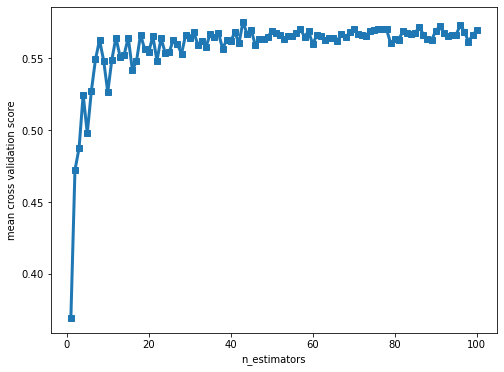

In [313]:
scores_no_dogs = []
for i in range (1, 101):
    forest_no_dogs = RandomForestRegressor(n_estimators=i)
    #print('n_estimators =', i)
    #model_fitter(forest, X_more_price_train, y_more_price_train, X_more_price_test, y_more_price_test)
    #print ('-'*55, '\n')
    score = cross_val_score(forest_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, cv=5)
    scores_no_dogs.append(score.mean())
plt.figure(figsize=(8,6))
plt.plot(range(1,101), scores_no_dogs, lw=3, marker='s')
plt.xlabel('n_estimators')
plt.ylabel('mean cross validation score')
plt.show()

In [314]:
i_max_no_dogs = np.argmax(scores_no_dogs)+1
i_max_no_dogs

43

In [315]:
forest_dogs = RandomForestRegressor(n_estimators=i_max_no_dogs)
model_fitter(forest_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5654032982753289
the training score is 0.8373724873403752
the test score is 0.5898875505519918


In [316]:
RMSE(forest_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

50228.84070446892

In [318]:
base_estimator = DecisionTreeRegressor(max_depth = 7)
Ada_no_dogs = AdaBoostRegressor(base_estimator = base_estimator, n_estimators = 100, random_state = 42)
model_fitter(Ada_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.2092885634699999
the training score is -1.2950662428967123
the test score is -1.312301064938639


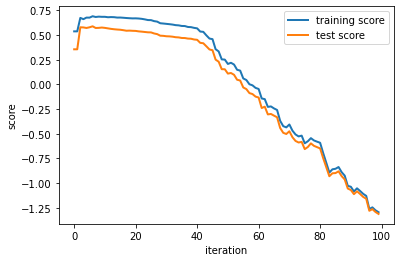

In [319]:
plt.plot(list(Ada_no_dogs.staged_score(X_more_price_no_dogs_train, y_more_price_no_dogs_train)),
         label='training score', lw=2)
plt.plot(list(Ada_no_dogs.staged_score(X_more_price_no_dogs_test, y_more_price_no_dogs_test)), label='test score', lw=2)
plt.xlabel('iteration')
plt.ylabel('score')
plt.legend()
plt.show()

In [320]:
RMSE(Ada_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

482921.8053077488

In [321]:
Gboost_no_dogs = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=7,
    learning_rate=0.1,
    random_state=1)
model_fitter(Gboost_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5869383815391225
the training score is 0.7769252993641635
the test score is 0.6083754787313942


In [323]:
RMSE(Gboost_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

57787.03108664342

In [324]:
ols_no_dogs = sm.OLS(y_more_price_no_dogs, sm.add_constant(X_more_price_no_dogs))
results = ols_no_dogs.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     117.1
Date:                Thu, 23 Jun 2022   Prob (F-statistic):               0.00
Time:                        01:17:02   Log-Likelihood:            -1.5181e+05
No. Observations:               21399   AIC:                         3.042e+05
Df Residuals:                   21133   BIC:                         3.063e+05
Df Model:                         265                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                           269.5015      2.332    115.581      0.000     264.931     274.072
pet_type_birds                 2.757e+14   9.62e+13      2.867      0.004    8.72e+13    4.64e+14
pet_type_cats                   5.09e+14   1.78e+14      2.867      0.004    1.61e+14    8.57e+14
pet_type_fish                  1.971e+14   6.88e+13      2.867      0.004    6.23e+13    3.32e+14
pet_type_horses               -1.176e+14   2.41e+14     -0.487      0.626   -5.91e+14    3.56e+14
pet_type_invertebrates         1.134e+14   3.96e+13      2.867      0.004    3.59e+13    1.91e+14
pet_type_livestock             8.293e+13   2.89e+13      2.867      0.004    2.62e+13     1.4e+14
pet_type_poultry               2.374e+14   8.28e+13      2.867      0.004    7.51e+13       4e+14
pet_type_rabbits                3.82e+14   1.33e+14      2.867      0.004    1.21e+14    6.43e+14
pet_type_reptiles              2.732e+14   9.53e+13      2.867      0.004    8.64e+13     4.6e+14
pet_type_rodents               2.931e+14   1.02e+14      2.867      0.004    9.27e+13    4.93e+14
seller_type_Breeder            4.545e+14   5.78e+14      0.786      0.432   -6.78e+14    1.59e+15
seller_type_Company            1.105e+13   1.41e+13      0.786      0.432   -1.65e+13    3.86e+13
seller_type_Individual         4.596e+14   5.84e+14      0.786      0.432   -6.86e+14    1.61e+15
seller_type_Licensed Breeder   1.284e+14   1.63e+14      0.786      0.432   -1.92e+14    4.48e+14
seller_type_Rescue/Charity     7.864e+13      1e+14      0.786      0.432   -1.17e+14    2.75e+14
listing_type_adoption          2.367e+13   5.87e+13      0.403      0.687   -9.15e+13    1.39e+14
listing_type_sale              3.158e+13   7.84e+13      0.403      0.687   -1.22e+14    1.85e+14
listing_type_stud              2.194e+13   5.44e+13      0.403      0.687   -8.48e+13    1.29e+14
species_Abyssinian            -1.199e+13   3.72e+12     -3.223      0.001   -1.93e+13    -4.7e+12
species_Aegean                -7.279e+12   2.26e+12     -3.223      0.001   -1.17e+13   -2.85e+12
species_Alaska                -5.503e+12   1.71e+12     -3.223      0.001   -8.85e+12   -2.16e+12
species_Alpaca                -7.279e+12   2.26e+12     -3.223      0.001   -1.17e+13   -2.85e+12
species_American Bobtail      -6.739e+12   2.09e+12     -3.223      0.001   -1.08e+13   -2.64e+12
species_American Curl         -5.503e+12   1.71e+12     -3.223      0.001   -8.85e+12   -2.16e+12
species_American Shorthair    -1.672e+13   5.19e+12     -3.223      0.001   -2.69e+13   -6.55e+12
species_American Standardbred   1.95e+13   2.15e+13      0.909      0.364   -2.26e+13    6.16e+13
species_Andalusian              1.95e+13   2.15e+13      0.909      0.364   -2.26e+13    6.16e+13
species_Angelfish             -1.506e+13   4.

In [325]:
nnet_no_dogs = MLPRegressor(hidden_layer_sizes=(4), solver='lbfgs',
                    activation='identity', max_iter=100000, 
                    alpha=10**(-12), 
                    random_state=1)
model_fitter(nnet_no_dogs, X_more_price_no_dogs_train, y_more_price_no_dogs_train, X_more_price_no_dogs_test,
             y_more_price_no_dogs_test)

the cv score is 0.5219623002989864
the training score is 0.6067022497365586
the test score is 0.5242907021481682


In [326]:
RMSE(nnet_no_dogs, X_more_price_no_dogs, y_more_price_no_dogs)

87922.11415591337

# Predicting Price with Best Models

In [361]:
df_clean['Gboost'] = abs(Gboost.predict(X_more_price))

In [362]:
df_clean['Gboost_difference'] = Gboost.predict(X_more_price)-df_clean['price']

In [363]:
df_clean['Gboost_difference'].describe()

count    41664.000000
mean        -0.165941
std        471.110310
min     -16601.398979
25%        -76.769833
50%         39.695575
75%        143.470811
max       5602.940704
Name: Gboost_difference, dtype: float64

In [379]:
df_clean.sort_values(by=['Gboost_difference'], ascending=True).head(30)

Title    price  \
8729                           2 female fluffy frenchies  18000.0   
38823          *STUNNING LITTER ALL FLUFF0Y L1 CARRIERS*  17148.0   
7381                  Fluffy Frenchie and Fluffy Carrier  16000.0   
27883  Stunning Cream Boy Carrying PINK 💗 ❌Pied ❌Brindle  20000.0   
18071                          kc reg red poodle puppies  22000.0   
25074                          French bulldogs for sale   15000.0   
28223           Lilac & Tan Platinum Carrying Pink (caL)  18000.0   
36762                       Merle Fluffy Carrier Female   15000.0   
15584                                Isabella Merle Male  12500.0   
28042           Outstading Cream, Pink (caL) Carrier Boy  15000.0   
23220      First merle Billy the kid pups in the world!   12000.0   
7281                    Lilac and Tan carrying isabella   10000.0   
3239     Catahoula Leopard Dog puppies puppy not pointer   9999.0   
5643           lilac and tan fluffy carrier adult female  10000.0   
39977                       4 Pedigree Shihtzu Boys left  12500.0   
23000                            VITA X BILLY THE KID !   10000.0   
8318                             VITA X BILLY THE KID !   10000.0   
24989                     BOSSY CONGO X MAJESTY BREEDING  10000.0   
13427                            Visual fluffy frenchie    8500.0   
9265                             Visual fluffy frenchie    8500.0   
38462     Full Isabella female ready to for her new home   8000.0   
25810  Kc baby cookies fozzy male testable and l4 car...   8000.0   
15602               Top Champion Pedigree Pocket Bullies   7999.0   
41146                         lilac Merle chow chow stud   6000.0   
18088            KC* 2nd in the world STARBUCKS Litter ！  10000.0   
36837                              American micro bullys   7500.0   
38215       French Bulldog VISUAL and carrying Fluffy!!!   7000.0   
24851                                 EXOTIC MICRO BULLY   6500.0   
15913                      American Bully Puppys 4 girls   6000.0   
31712               Amazing Chow Chows. Merles & Solids    8000.0   

                species        age   gender  \
8729     French Bulldog   12 weeks   Female   
38823    French Bulldog     1 year  unknown   
7381     French Bulldog   12 weeks   Female   
27883    French Bulldog    8 weeks     Male   
18071            Poodle    8 weeks    Mixed   
25074    French Bulldog   10 weeks    Mixed   
28223    French Bulldog    8 weeks  unknown   
36762    French Bulldog     1 year   Female   
15584    French Bulldog    8 weeks     Male   
28042    French Bulldog    8 weeks     Male   
23220    American Bully   12 weeks    Mixed   
7281     French Bulldog    3 years  unknown   
3239        Mixed Breed   14 weeks    Mixed   
5643     French Bulldog   9 months  unknown   
39977          Shih Tzu    5 weeks     Male   
23000    American Bully    7 weeks    Mixed   
8318     American Bully    8 weeks    Mixed   
24989    American Bully    7 weeks  unknown   
13427    French Bulldog  11 months  unknown   
9265     French Bulldog  10 months  unknown   
38462    French Bulldog   13 weeks    Mixed   
25810    French Bulldog   7 months  unknown   
15602    American Bully    6 weeks    Mixed   
41146         Chow Chow    3 years  unknown   
18088         Chow Chow    3 weeks    Mixed   
36837    American Bully   14 weeks    Mixed   
38215    French Bulldog    5 weeks    Mixed   
24851    French Bulldog    8 weeks    Mixed   
15913  American Bulldog     1 year  unknown   
31712         Chow Chow    5 weeks    Mixed   

                                             description  \
8729   1xfluffy carrier girl -blue and tan B/b E/e £6...   
38823  Our amazing Nala coat color   DNA: ? AtAt/dd/c...   
7381   We have 2 Sister for sale.The first is a full ...   
27883  I have one stunning quality boy available. No ...   
18071  beautiful thick coats and very sociable happy ...   
25074  1 x female lilac and tan carrying testable cho...   
28223  I have one stunning qualit

In [383]:
df_clean.loc[df_clean['Gboost_difference'] < 0.0].sort_values(by=['Gboost_difference'], ascending=True)

Title    price  \
8729                           2 female fluffy frenchies  18000.0   
38823          *STUNNING LITTER ALL FLUFF0Y L1 CARRIERS*  17148.0   
7381                  Fluffy Frenchie and Fluffy Carrier  16000.0   
27883  Stunning Cream Boy Carrying PINK 💗 ❌Pied ❌Brindle  20000.0   
18071                          kc reg red poodle puppies  22000.0   
...                                                  ...      ...   
30907                        Ko shamo x jubilee game hen     50.0   
7094                     Geese available various breeds      50.0   
15916                       Gold Silkies for Sale (Pair)     50.0   
7080                                  Ducklings for sale     50.0   
29495                          Fluffy beautiful kittens     180.0   

              species       age   gender  \
8729   French Bulldog  12 weeks   Female   
38823  French Bulldog    1 year  unknown   
7381   French Bulldog  12 weeks   Female   
27883  French Bulldog   8 weeks     Male   
18071          Poodle   8 weeks    Mixed   
...               ...       ...      ...   
30907        Chickens   6 weeks     Male   
7094            Geese   7 weeks    Mixed   
15916        Chickens  14 weeks    Mixed   
7080            Ducks  3 months    Mixed   
29495     Mixed Breed   5 weeks    Mixed   

                                             description   seller_name  \
8729   1xfluffy carrier girl -blue and tan B/b E/e £6...    miranda w.   
38823  Our amazing Nala coat color   DNA: ? AtAt/dd/c...     Daniel A.   
7381   We have 2 Sister for sale.The first is a full ...     Wesley s.   
27883  I have one stunning quality boy available. No ...   Lottiebullz   
18071  beautiful thick coats and very sociable happy ...  Norma bosley   
...                                                  ...           ...   
30907  A very rare cross jubilee game hen cross with ...       Tony Y.   
7094   Geese available various breeds  American brown...       Matt R.   
15916  Hello, Thanks for looking, please find my poin...     Wesley E.   
7080   Selling  pekin ducks with pen bedding and food...      amber d.   
29495  4 fluffy Kittens with long fur born 29/04and l...    Pavlina I.   

      seller_location seller_type listing_type pet_type      year  \
8729         Alcester  Individual         sale     dogs  0.230769   
38823       Liverpool  Individual         sale     dogs  1.000000   
7381         Alcester  Individual         sale     dogs  0.230769   
27883          Durham     Breeder         sale     dogs  0.153846   
18071        Bridgend     Breeder         sale     dogs  0.153846   
...               ...         ...          ...      ...       ...   
30907            Hook  Individual         sale  poultry  0.115385   
7094    Kidderminster  Individual         sale  poultry  0.134615   
15916    Bognor Regis  Individual         sale  poultry  0.269231   
7080       Wednesbury  Individual         sale  poultry  0.250000   
29495         Croydon  Individual         sale     cats  0.096154   

            Gboost  Gboost_difference  
8729   1398.601021      -16601.398979  
38823  1427.387907      -15720.612093  
7381   1398.601021      -14601.398979  
27883  5523.050181      -14476.949819  
18071  7802.940704      -14197.059296  
...            ...                ...  
30907    49.955200          -0.044800  
7094     49.955200          -0.044800  
15916    49.955200          -0.044800  
7080     49.955200          -0.044800  
29495   179.994045          -0.005955  

[15100 rows x 14 columns]

In [384]:
df_clean.loc[df_clean['Gboost_difference'] > 0.0].sort_values(by=['Gboost_difference'], ascending=True)

Title   price  \
25101                  Beautiful Male Chihuahua For Sale   700.0   
15595          Extensively health tested cavapoo puppies  1250.0   
32234                              Ruby Red cavaPoos F1b  1250.0   
17106                      Beautiful Red Cavapoo Puppies  1250.0   
29141                   Lovebird Breeding Pair with Eggs   125.0   
...                                                  ...     ...   
33297                             Welsh d mare for loan    120.0   
7859                    Miniature wired hair dachshund     800.0   
7968   READY TO GO Stunning Merle french bulldog puppies  2000.0   
39959                             4 Male French Bulldogs  1550.0   
18006                          kc reg red poodle puppies  2200.0   

                   species       age   gender  \
25101            Chihuahua   2 years     Male   
15595              Cavapoo  10 weeks    Mixed   
32234              Cavapoo  13 weeks    Mixed   
17106              Cavapoo  13 weeks    Mixed   
29141            Lovebirds    1 year    Mixed   
...                    ...       ...      ...   
33297      Welsh Section D      2017     Mare   
7859   Miniature Dachshund  5 months  unknown   
7968        French Bulldog   8 weeks     Male   
39959       French Bulldog   8 weeks     Male   
18006               Poodle   8 weeks    Mixed   

                                             description   seller_name  \
25101  Beautiful Chihuahua For Sale  Just over 2 year...   Michelle L.   
15595  I am proud to introduce my wonderful cavapoo p...         Jo P.   
32234  Here we have my little girls first litter of R...        Ida C.   
17106  Our beautiful ruby red cavalier has given birt...     Lauren P.   
29141  07912186069   - Cuddly, entertaining, happy, f...            KC   
...                                                  ...           ...   
33297  Possibly looking for a part loaner for my 14.2...      Chloe P.   
7859   Hi I’m currently doing this advert for my mom ...      aidan p.   
7968   We are pleased to announce our gorgeous girl M...       Josh H.   
39959  This is our Cocos lovely litter of 4 males loo...        Millie   
18006  beautiful little fur babies reared by us with ...  Norma bosley   

           seller_location seller_type listing_type pet_type      year  \
25101           Shrewsbury  Individual         sale     dogs  2.000000   
15595         Bognor Regis  Individual         sale     dogs  0.192308   
32234               Tadley  Individual         sale     dogs  0.250000   
17106              Cwmbran  Individual         sale     dogs  0.250000   
29141             Richmond     Breeder         sale    birds  1.000000   
...                    ...         ...          ...      ...       ...   
33297           Portsmouth     Breeder         sale   horses  5.000000   
7859   Stourport-on-Severn  Individual         sale     dogs  0.416667   
7968          Kingswinford     Breeder         sale     dogs  0.153846   
39959                Leeds     Breeder         sale     dogs  0.153846   
18006             Bridgend     Breeder         sale     dogs  0.153846   

            Gboost  Gboost_difference  
25101   700.088081           0.088081  
15595  1250.094919           0.094919  
32234  1250.094919           0.094919  
17106  1250.094919           0.094919  
29141   125.100851           0.100851  
...            ...                ...  
33297  3477.933694        3357.933694  
7859   4259.679400        3459.679400  
7968   5523.050181        3523.050181  
39959  5523.050181        3973.050181  
18006  7802.940704        5602.940704  

[26564 rows x 14 columns]

In [380]:
def pred_plot_box (data, column):
    entries = data[column].unique()
    for entry in entries:
        plt.figure(figsize=(8,6))
        plt.xticks(rotation=90)
        sns.boxplot(x = data.loc[data[column] == entry].Gboost_difference).set_title(entry)
        plt.show()

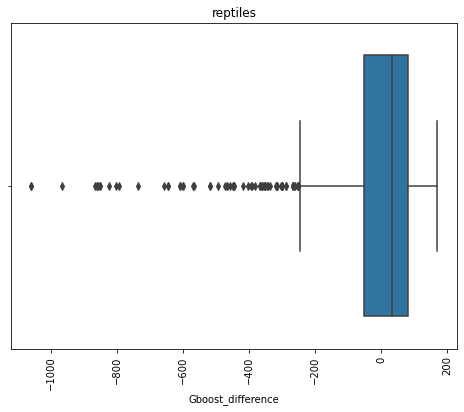

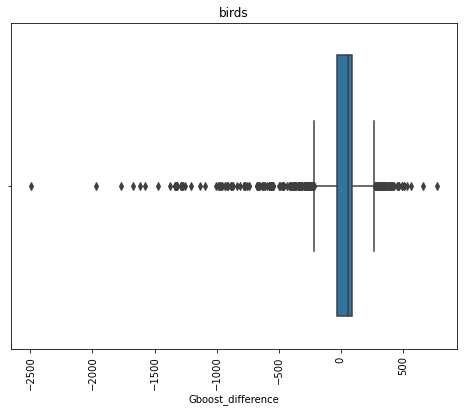

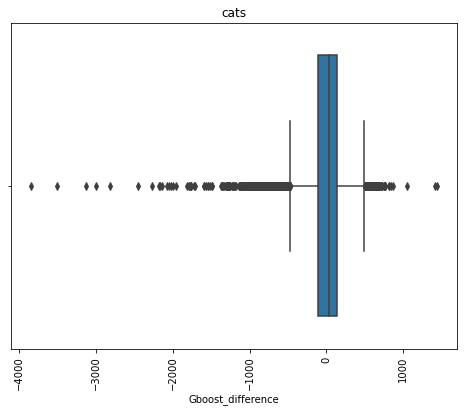

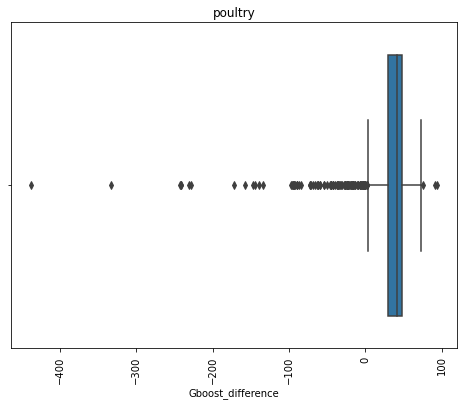

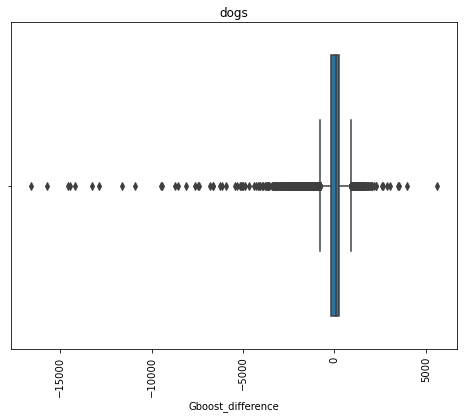

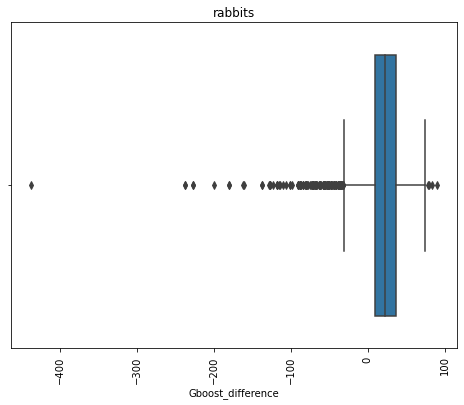

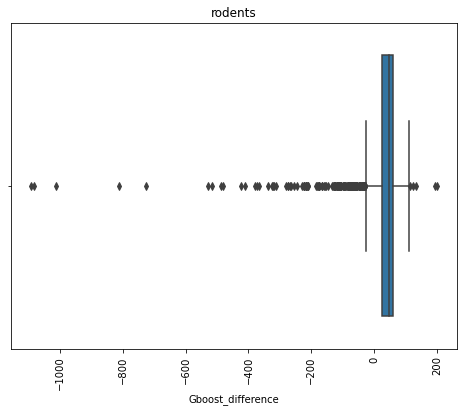

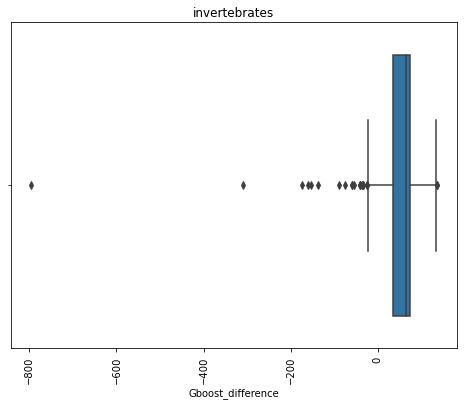

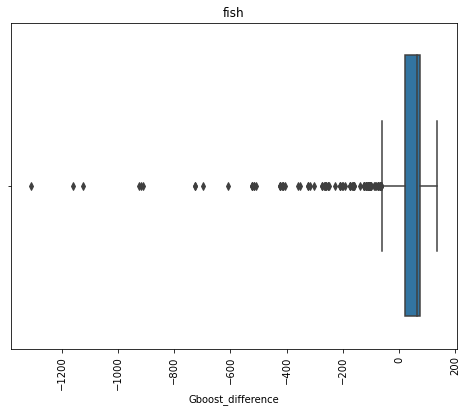

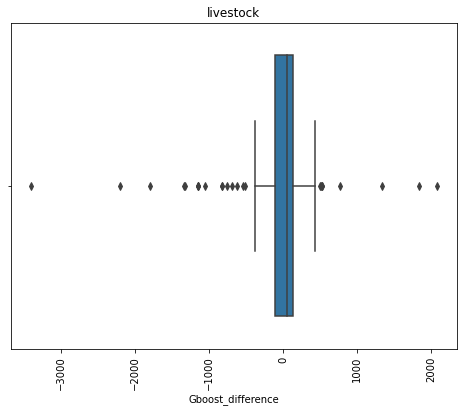

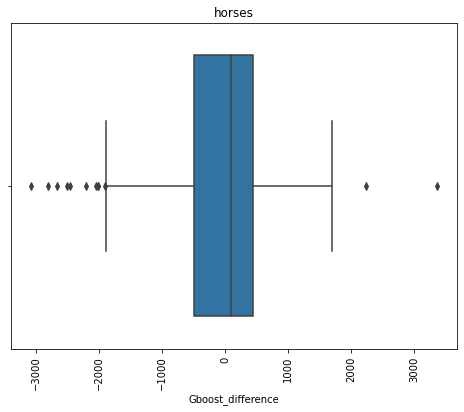

In [381]:
pred_plot_box (df_clean,'pet_type')

In [368]:
dogs['Gboost'] = abs(Gboost_dogs.predict(X_more_price_dogs))

In [369]:
dogs['Gboost_difference'] = dogs['Gboost']-dogs['price']

In [370]:
dogs['Gboost_difference'].describe()

count    20265.000000
mean         0.456692
std        623.196203
min     -16926.730547
25%       -151.938495
50%         63.005722
75%        269.552964
max      13032.864819
Name: Gboost_difference, dtype: float64

In [372]:
no_dogs['Gboost'] = abs(Gboost_no_dogs.predict(X_more_price_no_dogs))

In [373]:
no_dogs['Gboost_difference'] = no_dogs['Gboost']-no_dogs['price']

In [374]:
no_dogs['Gboost_difference'].describe()

count    21399.000000
mean        -1.934079
std        240.372103
min      -5424.412383
25%        -29.594016
50%         20.034360
75%         59.050483
max       3319.756185
Name: Gboost_difference, dtype: float64

In [376]:
no_dogs.sort_values(by=['Gboost_difference'], ascending=True).head(30)

Title   price  \
13033           Perfect Allrounder Teenagers Dream 14.2   8500.0   
8746                                stunning Welsh sec c  6500.0   
16222                                          Breading   4500.0   
2555                    British shorthair kittens + mom   4000.0   
247    PERFECTLY MARKED Group 1 Valais Blacknose Ewe ...  4200.0   
7916                                      Blue elf male.  3750.0   
13172         Stunning 3yr okd 15hh registered PRE mare   6000.0   
17625                   Beautiful belgian draft yearling  4000.0   
6345                                        Savannah f3   3500.0   
9272                                     Bow 15.2hh cob   8500.0   
9282                    13hh Skewbald Allrounder Gelding  3250.0   
3296                                           Miss Mrs   2600.0   
8356                       blue pointed ragdoll for sale  3000.0   
16378       Active TICA registered blue bicolour Ragdoll  3000.0   
9277                          Perfect teenagers Eventer   5500.0   
7654                     Blue point boy Tica registered.  2800.0   
6459                                    Savannah f2 male  3500.0   
10729                 Silver charcoal active Bengal male  2500.0   
7223                             Handsome 15.2hh gelding  5500.0   
260                                   Hart braking sale   3000.0   
15753                                           Mr Jumbo  2700.0   
6327                        Blue Mitted European Ragdoll  2800.0   
8661            HAND REARED BABY SILLY TAME AFRICAN GREY  2395.0   
6112                           5 savannah cats for sale   4500.0   
6448             GCCF Active registered blue point male   2500.0   
13922   *Ghost Silver Snow Carrier Russian Import Lines*  2500.0   
7216                        xXx Adult Queens and Male Xx  2500.0   
9142                        xXx Adult Queens and Male Xx  2500.0   
9284                               BRUNO THE TURBO COB 🐴  5500.0   
17626              *Stunning Welsh Section C Allrounder*  5200.0   

                    species        age   gender  \
13033             Connemara       2011  Gelding   
8746        Welsh Section C       2007     Mare   
16222         Scottish Fold  11 months    Mixed   
2555      British Shorthair    5 weeks    Mixed   
247                   Sheep   5 months   Female   
7916                 Sphynx     1 year     Male   
13172            Andalusian       2019     Mare   
17625     Belgian Warmblood       2021     Mare   
6345               Savannah     1 year   Female   
9272              Irish Cob       2008     Mare   
9282            Riding pony       2004  Gelding   
3296            Mixed Breed   14 weeks    Mixed   
8356                Ragdoll    5 weeks     Male   
16378               Ragdoll     1 year  unknown   
9277   English Thoroughbred       2019     Mare   
7654                 Sphynx     1 year     Male   
6459               Savannah    4 years     Male   
10729                Bengal    2 years  unknown   
7223        Welsh Section D       2007  Gelding   
260         Welsh Section A       2006     Mare   
15753                Sphynx    9 weeks     Male   
6327                Ragdoll     1 year  unknown   
8661                Parrots   4 months    Mixed   
6112               Savannah    2 years  unknown   
6448                Ragdoll     1 year     Male   
13922                Bengal    2 years     Male   
7216                 Bengal  11 months    Mixed   
9142                 Bengal     1 year    Mixed   
9284              Irish Cob       2015  Gelding   
17626       Welsh Section C       2012  Gelding   

                                             description  \
13033  ⭐️⭐️ Husky ⭐️⭐️    10Yo Connemara x Newforest ...   
8746   Meet Lilly. She is approximately 13.3hh regist...   
16222  Stunning scottish fold couple(active for breed...   
2555   Due to busy life we are selling our kittens an...   
247    We have just one ewe lamb available and she's ...   
